In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
az.rcParams["stats.information_criterion"] = "waic"  # set information criterion to use in `compare`
az.rcParams["stats.ic_scale"] = "deviance"  # set information criterion scale
np.random.seed(0)

#### Code 8.1

In [3]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

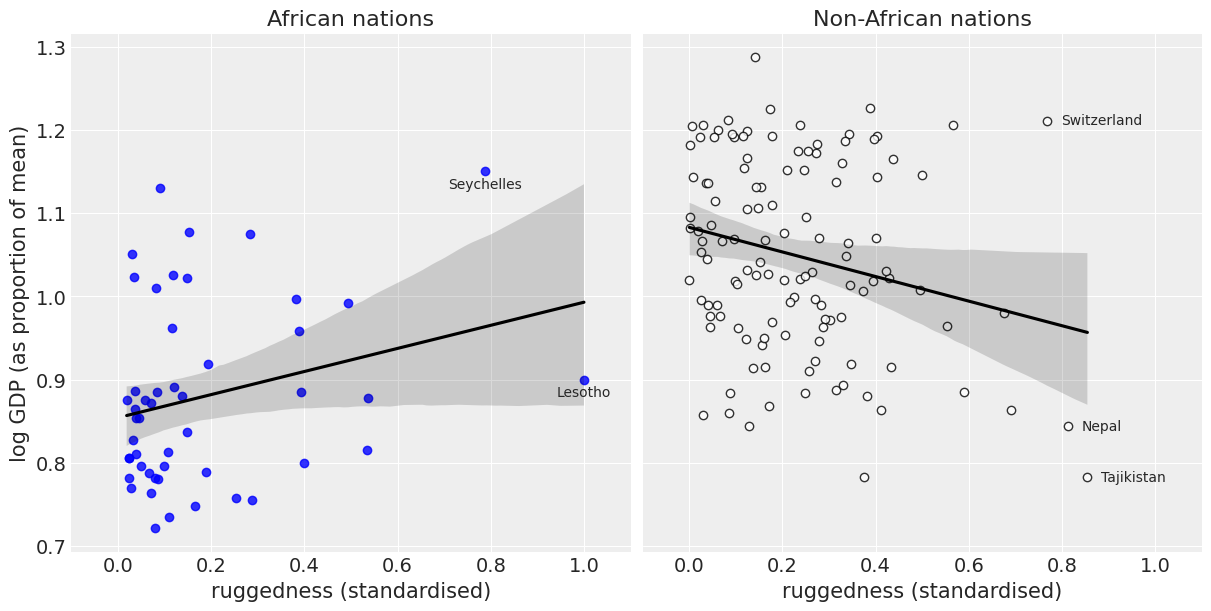

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.regplot(
    x=dd.loc[dd["cont_africa"] == 1]["rugged_std"],
    y=dd.loc[dd["cont_africa"] == 1]["log_gdp_std"],
    scatter_kws={"color": "b"},
    line_kws={"color": "k"},
    ax=axs[0],
)
sns.regplot(
    x=dd.loc[dd["cont_africa"] == 0]["rugged_std"],
    y=dd.loc[dd["cont_africa"] == 0]["log_gdp_std"],
    scatter_kws={"edgecolor": "k", "facecolor": "w"},
    line_kws={"color": "k"},
    ax=axs[1],
)

axs[0].set_ylabel("log GDP (as proportion of mean)")
axs[1].set_ylabel("")
axs[0].set_title("African nations")
axs[1].set_title("Non-African nations")

# label countries
for _, africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 1)].iterrows():
    axs[0].text(
        africa["rugged_std"],
        africa["log_gdp_std"] - 0.02,
        africa["country"],
        ha="center",
    )

for _, non_africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 0)].iterrows():
    axs[1].text(
        non_africa["rugged_std"] + 0.03,
        non_africa["log_gdp_std"],
        non_africa["country"],
        va="center",
    )

for ax in axs:
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("ruggedness (standardised)")

#### Code 8.2

In [6]:
with pm.Model() as m_8_1:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)

    mu = a + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, shape=dd.shape[0])

#### Code 8.3

In [7]:
with m_8_1:
    m_8_1_prior = pm.sample_prior_predictive()

# Figure 8.3 is below

Sampling: [a, b, log_gdp_std, sigma]


#### Code 8.4

In [8]:
beta_prior = az.extract_dataset(m_8_1_prior.prior)["b"].to_numpy()
np.sum(np.abs(beta_prior > 0.6)) / len(beta_prior)

np.float64(0.29)

#### Code 8.5

In [9]:
with pm.Model() as m_8_1t:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)

    mu = a + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_1t_trace = pm.sample()

    m_8_1t_prior = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
Sampling: [a, b, log_gdp_std, sigma]


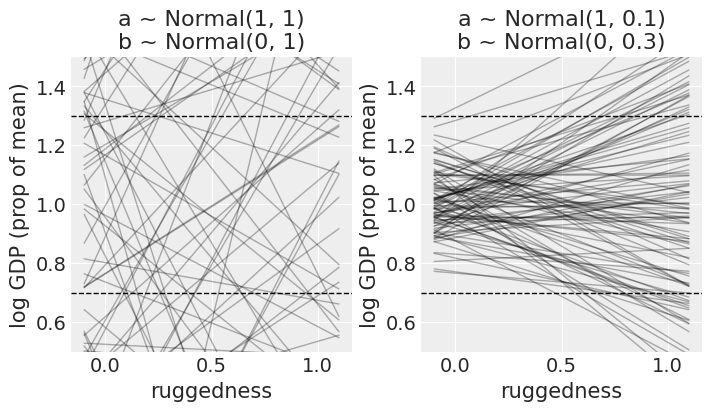

In [10]:
# Figure 8.3

_, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 4], constrained_layout=True)

n = 100
rugged_plot = np.linspace(-0.1, 1.1, n)

# Prior 1
prior = m_8_1_prior.prior.sel(draw=slice(None, None, int(len(m_8_1_prior.prior.draw) / n)))
reglines = prior["a"].T.to_numpy() + rugged_plot * prior["b"].T.to_numpy()
for regline in reglines:
    ax1.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax1.set_title("a ~ Normal(1, 1)\nb ~ Normal(0, 1)")

# Prior 2
prior_t = m_8_1t_prior.prior.sel(draw=slice(None, None, int(len(m_8_1t_prior.prior.draw) / n)))
reglines_t = prior_t["a"].T.to_numpy() + rugged_plot * prior_t["b"].T.to_numpy()

for regline in reglines_t:
    ax2.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax2.set_title("a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_ylabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)

#### Code 8.6

In [11]:
az.summary(m_8_1t_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.08,0.09
sigma,0.14,0.01,0.13,0.15


#### Code 8.7

In [12]:
cid = pd.Categorical(dd["cont_africa"])

#### Code 8.8

In [13]:
with pm.Model() as m_8_2:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3)

    mu = a[np.array(cid)] + b * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_2_trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


#### Code 8.9

In [17]:
# Add log_likelihood to inference data
idata_8_1t = pm.compute_log_likelihood(m_8_1t_trace, model=m_8_1t, extend_inferencedata=True)
idata_8_2 = pm.compute_log_likelihood(m_8_2_trace, model=m_8_2, extend_inferencedata=True)

# Then compare
az.compare({"m_8_1t": idata_8_1t, "m_8_2": idata_8_2})

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m_8_2,0,-252.374373,4.100547,0.000000,0.970054,14.805829,0.000000,True,deviance
m_8_1t,1,-188.763604,2.607398,63.610769,0.029946,12.940617,14.616868,False,deviance


#### Code 8.10

In [18]:
az.summary(m_8_2_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.06
a[1],0.88,0.02,0.85,0.91
b,-0.05,0.05,-0.12,0.02
sigma,0.11,0.01,0.10,0.12


#### Code 8.11

In [19]:
m_8_2_posterior = az.extract_dataset(m_8_2_trace.posterior)
diff_a0_a1 = m_8_2_posterior["a"][1, :] - m_8_2_posterior["a"][0, :]
az.hdi(diff_a0_a1.to_numpy())

array([-0.19813955, -0.13813425])

#### Code 8.12

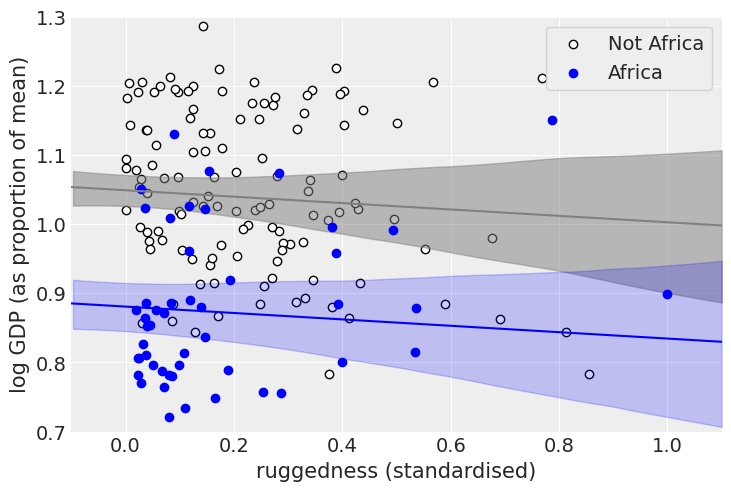

In [20]:
fig, ax = plt.subplots()

# extract posterior samples of parameters
a0 = m_8_2_posterior["a"][0, :].to_numpy()
a1 = m_8_2_posterior["a"][1, :].to_numpy()
b = m_8_2_posterior["b"].to_numpy()

rugged_plot = np.linspace(-0.1, 1.1)

ax.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
pred0 = a0 + rugged_plot.reshape(-1, 1) * b
ax.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax)

ax.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
pred1 = a1 + rugged_plot.reshape(-1, 1) * b
ax.plot(rugged_plot, pred1.mean(1), color="b")
az.plot_hdi(rugged_plot, pred1.T, color="b", hdi_prob=0.97, ax=ax, fill_kwargs={"alpha": 0.2})

ax.legend(frameon=True)

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(0.7, 1.3)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)");

#### Code 8.13

In [24]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[np.array(cid)] + b[np.array(cid)] * (dd["rugged_std"].values - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    m_8_3_trace = pm.sample()
    idata_8_3 = pm.compute_log_likelihood(m_8_3_trace, model=m_8_3, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

#### Code 8.14

In [25]:
az.summary(m_8_3_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.89,0.02,0.86,0.91
b[0],-0.14,0.05,-0.23,-0.06
b[1],0.13,0.08,0.02,0.25
sigma,0.11,0.01,0.10,0.12


#### Code 8.15

In [26]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace, "m_8_3": m_8_3_trace}, ic="loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m_8_3,0,-259.311758,4.922866,0.000000,0.875547,14.629280,0.000000,False,deviance
m_8_2,1,-252.332480,4.121494,6.979278,0.124453,14.817123,6.444744,False,deviance
m_8_1t,2,-188.748686,2.614858,70.563072,0.000000,12.941760,14.923966,False,deviance


#### Code 8.16

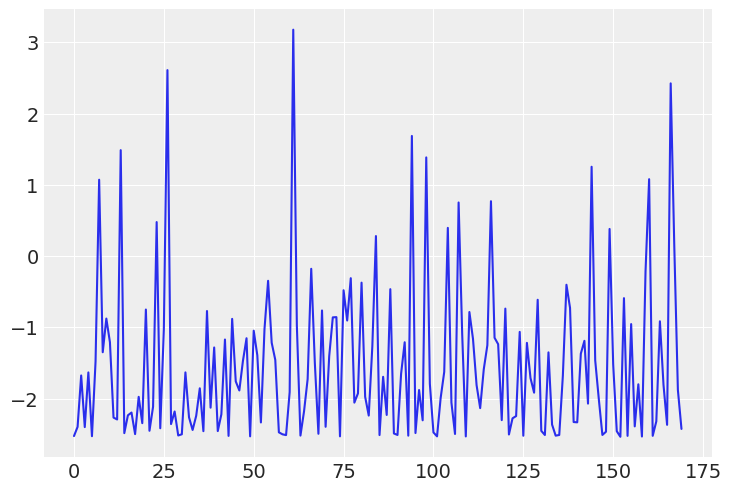

In [27]:
m_8_3_loo = az.loo(m_8_3_trace, pointwise=True)

plt.plot(m_8_3_loo.loo_i)

#### Code 8.17

In [28]:
m_8_3_posterior = az.extract_dataset(m_8_3_trace.posterior)

Text(0, 0.5, 'log GDP (as proportion of mean)')

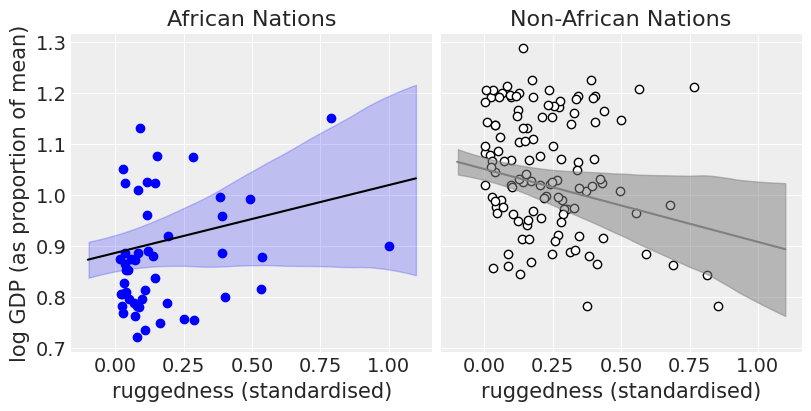

In [29]:
_, axs = plt.subplots(
    1,
    2,
    figsize=[8, 4],
    sharey=True,
    constrained_layout=True,
)

ax1, ax0 = axs

# extract posterior samples of parameters
a0 = m_8_3_posterior["a"][0, :].to_numpy()
a1 = m_8_3_posterior["a"][1, :].to_numpy()
b0 = m_8_3_posterior["b"][0, :].to_numpy()
b1 = m_8_3_posterior["b"][1, :].to_numpy()

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred0 = a0 + rugged_plot.reshape(-1, 1) * b0
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax0)
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred1 = a1 + rugged_plot.reshape(-1, 1) * b1
ax1.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hdi(
    rugged_plot,
    pred1.T,
    color="blue",
    hdi_prob=0.97,
    ax=ax1,
    fill_kwargs={"alpha": 0.2},
)
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax0.set_ylabel("")
ax1.set_ylabel("log GDP (as proportion of mean)")

#### Code 8.18

(0.0, 1.0)

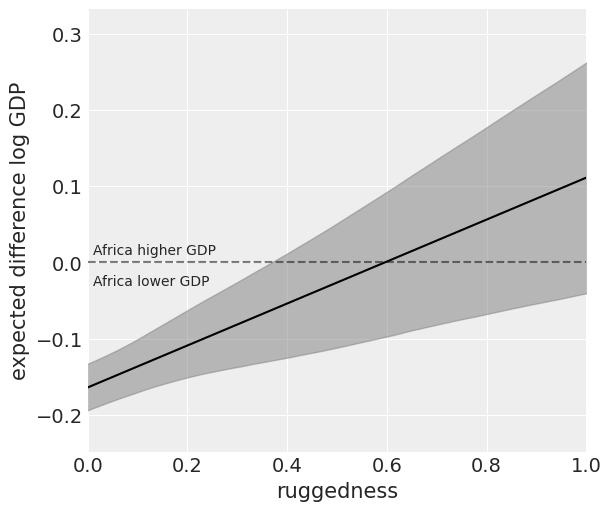

In [30]:
fig, ax = plt.subplots(figsize=(6, 5))

rugged_plot = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

ax.plot(rugged_plot, delta.mean(1), c="k")
az.plot_hdi(rugged_plot, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference log GDP")
ax.set_xlim(0, 1)

These numbers are quite different from the book - not sure why.

#### Code 8.19

In [3]:
d = pd.read_csv("Data/tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [4]:
d.shape

(27, 4)

$$B_i \sim Normal(\mu_i,\sigma)$$

$$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S})$$

#### Code 8.20

In [5]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

#### Code 8.21

In [6]:
a = stats.norm.rvs(0.5, 1, 10000)
sum((a < 0) | (a > 1)) / len(a)

np.float64(0.6092)

#### Code 8.22

In [34]:
a = stats.norm.rvs(0.5, 0.25, 10000)
sum((a < 0) | (a > 1)) / len(a)

np.float64(0.0447)

#### Code 8.23

In [35]:
with pm.Model() as m_8_4:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)

    mu = a + bw * d["water_cent"].values + bs * d["shade_cent"].values
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    m_8_4_trace = pm.sample()
    m_8_4_post = az.extract_dataset(m_8_4_trace.posterior)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


$$B_i \sim Normal(\mu_i,\sigma)$$

$$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S}) +\beta_{WS}W_iS_i $$

#### Code 8.24

In [123]:
with pm.Model() as m_8_5:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)

    mu = (
        a
        + bw * d["water_cent"].values
        + bs * d["shade_cent"].values
        + bws * d["water_cent"].values * d["shade_cent"].values
    )
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    m_8_5_trace = pm.sample()
    m_8_5_post = az.extract_dataset(m_8_5_trace.posterior)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, bws, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


#### Code 8.25

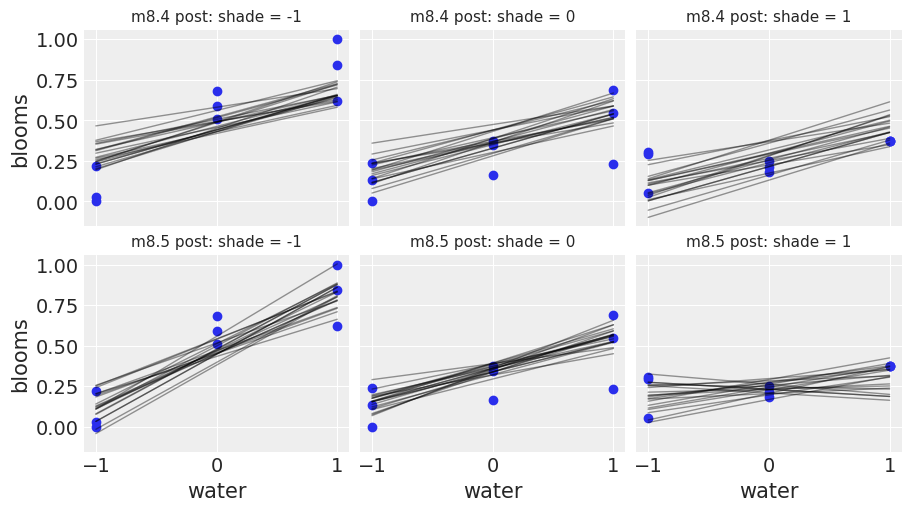

In [37]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(d.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_post["a"][:n_lines].to_numpy()
        + m_8_4_post["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_4_post["bs"][:n_lines].to_numpy() * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_post["a"][:n_lines].to_numpy()
        + m_8_5_post["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_5_post["bs"][:n_lines].to_numpy() * shade
        + m_8_5_post["bws"][:n_lines].to_numpy() * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

for ax in axs.flat:
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("blooms")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("water");

#### Code 8.26

In [38]:
with m_8_4:
    m_8_4_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs"])
    m_8_4_priors = az.extract_dataset(m_8_4_priors.prior)

with m_8_5:
    m_8_5_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs", "bws"])
    m_8_5_priors = az.extract_dataset(m_8_5_priors.prior)

Sampling: [a, bs, bw]
Sampling: [a, bs, bw, bws]


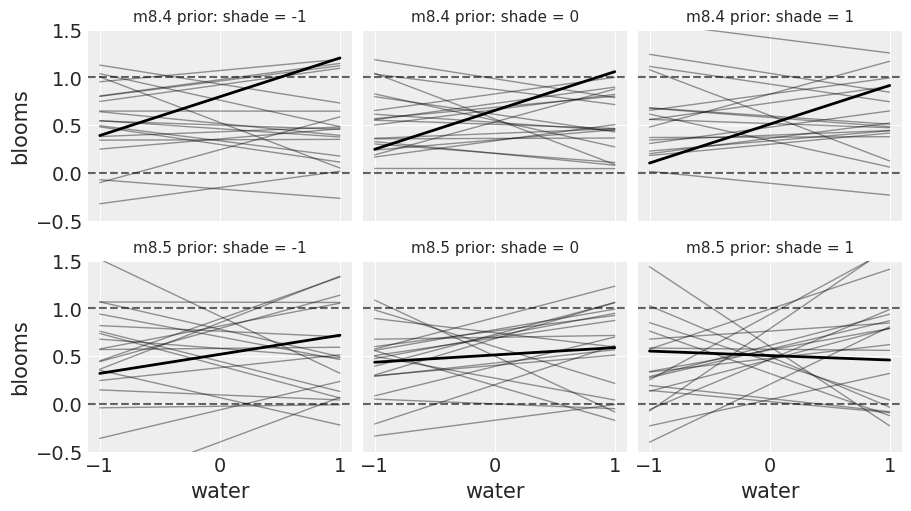

In [39]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_priors["a"][:n_lines].to_numpy()
        + m_8_4_priors["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_4_priors["bs"][:n_lines].to_numpy() * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_priors["a"][:n_lines].to_numpy()
        + m_8_5_priors["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
        + m_8_5_priors["bs"][:n_lines].to_numpy() * shade
        + m_8_5_priors["bws"][:n_lines].to_numpy() * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

for ax in axs.flat:
    ax.set_ylim(-0.5, 1.5)
    ax.axhline(1, ls="dashed", color=(0, 0, 0, 0.6))
    ax.axhline(0, ls="dashed", color=(0, 0, 0, 0.6))
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("blooms")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("water");

8M4.  Repeat the tulips analysis, but this time use priors that constrain the effect of water to be positive and the effect of shade to be negative. Use prior predictive simulation. What do these prior assumptions mean for the interaction prior, if anything?

In [7]:
d = pd.read_csv("Data/tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [8]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

<Axes: ylabel='shade_cent'>

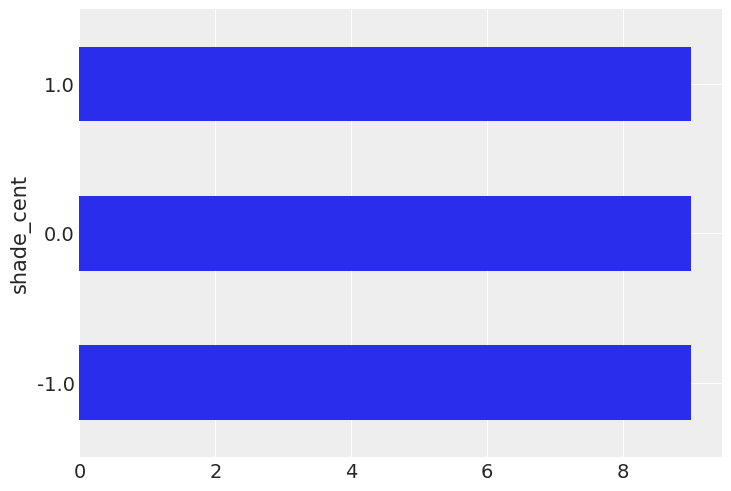

In [12]:
d["shade_cent"].value_counts().plot(kind='barh')

<Axes: ylabel='water_cent'>

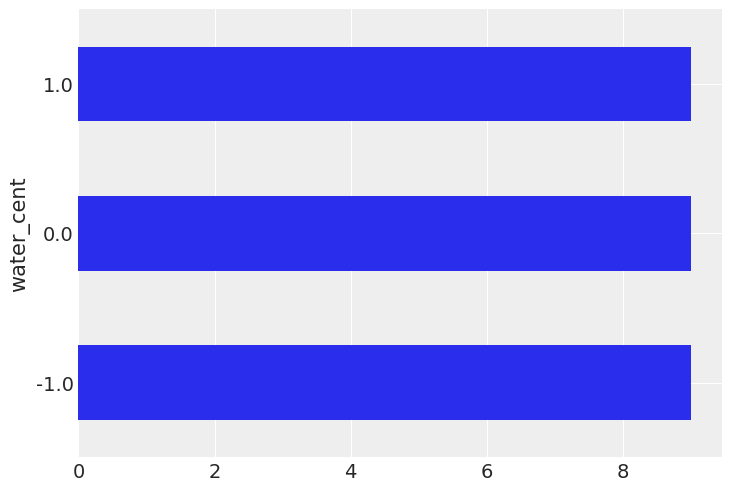

In [13]:
d["water_cent"].value_counts().plot(kind='barh')

<Axes: >

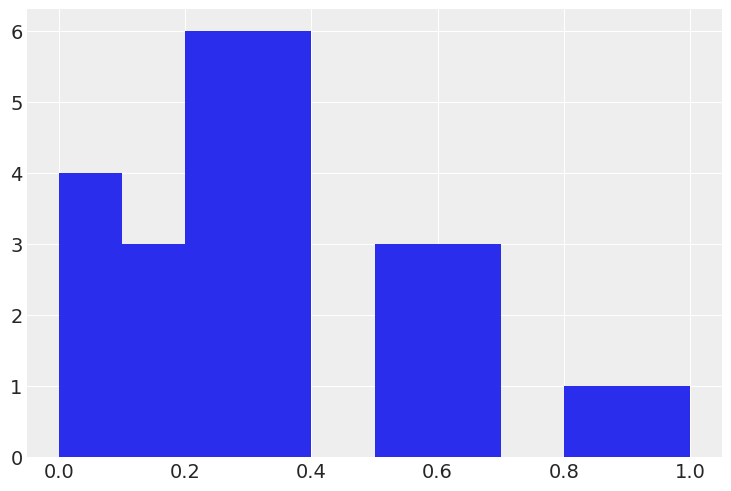

In [30]:
d["blooms_std"].hist()

In [93]:
with pm.Model() as m_8_5_log:
    a = pm.Normal("a", 0.5, 0.25)
    # bw = pm.LogNormal("bw", 0, 0.3)
    # bs = pm.LogNormal("bs", 0, 0.3)
    bw = pm.HalfNormal("bw", 0.3)
    bs = pm.HalfNormal("bs", 0.3)
    bws = pm.Normal("bws", 0, 0.25)

    mu = pm.Deterministic('mu',
        a
        + bw * d["water_cent"].values
        - bs * d["shade_cent"].values
        + bws * d["water_cent"].values * d["shade_cent"].values
    )
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    m_8_5_log_trace = pm.sample()
    m_8_5_log_prior = pm.sample_prior_predictive()
    m_8_5_log_post = az.extract_dataset(m_8_5_log_trace.posterior)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, bws, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
Sampling: [a, blooms_std, bs, bw, bws, sigma]


In [94]:
m_8_5_log_prior.prior_predictive.blooms_std

<xarray.DataArray 'blooms_std' (chain: 1, draw: 500, blooms_std_dim_0: 27)> Size: 108kB
array([[[  0.83144708,   0.01524197,  -0.03512333, ...,   0.53858847,
           0.88504165,   0.68982902],
        [ -0.37594012,  -0.62033332,  -0.03143712, ...,   0.3504276 ,
           1.2178998 ,   0.03171105],
        [  0.52365415,  -0.12551342,  -0.61521425, ...,   1.19161813,
           2.39186841,   1.00036783],
        ...,
        [ -4.22420386,  -9.32214736,  -6.08721382, ...,   1.15279757,
          -1.62737208, -10.43263787],
        [  0.22258661,  -0.27412729,  -0.30117202, ...,   1.86915115,
           1.08388376,   0.04412703],
        [ -1.31942348,   1.06414408,   0.13132523, ...,   1.43928052,
          -1.84599958,  -0.6763186 ]]], shape=(1, 500, 27))
Coordinates:
  * chain             (chain) int64 8B 0
  * draw              (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * blooms_std_dim_0  (blooms_std_dim_0) int64 216B 0 1 2 3 4 ... 22 23 24 25 26

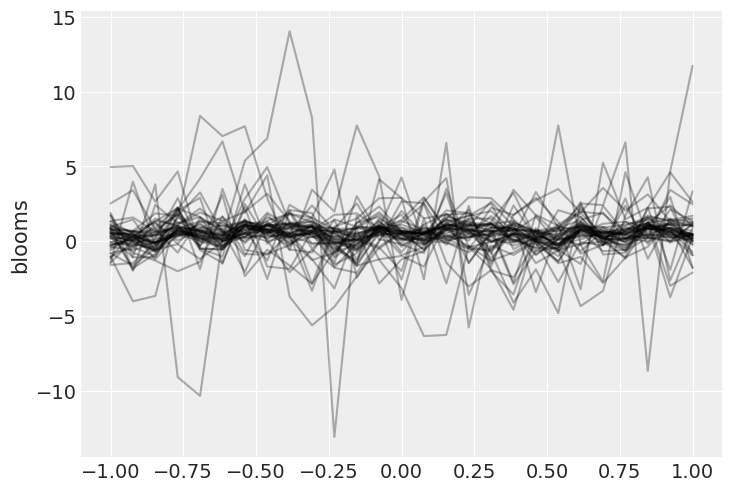

In [95]:
fig, ax = plt.subplots()
xseq =np.linspace(-1, 1, 27)
ppr_blooms = m_8_5_log_prior.prior_predictive["blooms_std"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_blooms[i], c="black", alpha=0.3)
# ax.set_xlim(xseq)
# ax.set_ylim(xseq)
# ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
# ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("blooms");

Text(0.5, 1.0, 'Prior Predictive Distribution')

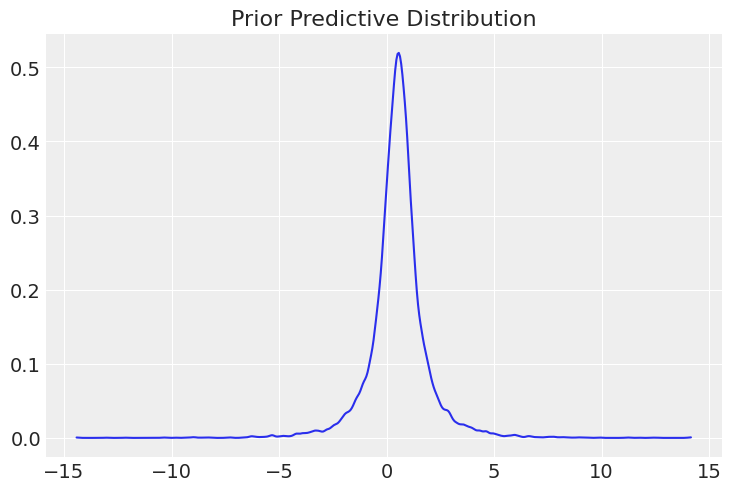

In [96]:
az.plot_dist(m_8_5_log_prior.prior_predictive["blooms_std"])
plt.title("Prior Predictive Distribution")

In [97]:
m_8_5_log_prior.prior_predictive

<xarray.Dataset> Size: 112kB
Dimensions:           (chain: 1, draw: 500, blooms_std_dim_0: 27)
Coordinates:
  * chain             (chain) int64 8B 0
  * draw              (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * blooms_std_dim_0  (blooms_std_dim_0) int64 216B 0 1 2 3 4 ... 22 23 24 25 26
Data variables:
    blooms_std        (chain, draw, blooms_std_dim_0) float64 108kB 0.8314 .....
Attributes:
    created_at:                 2025-06-26T06:41:18.347185+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.23.0

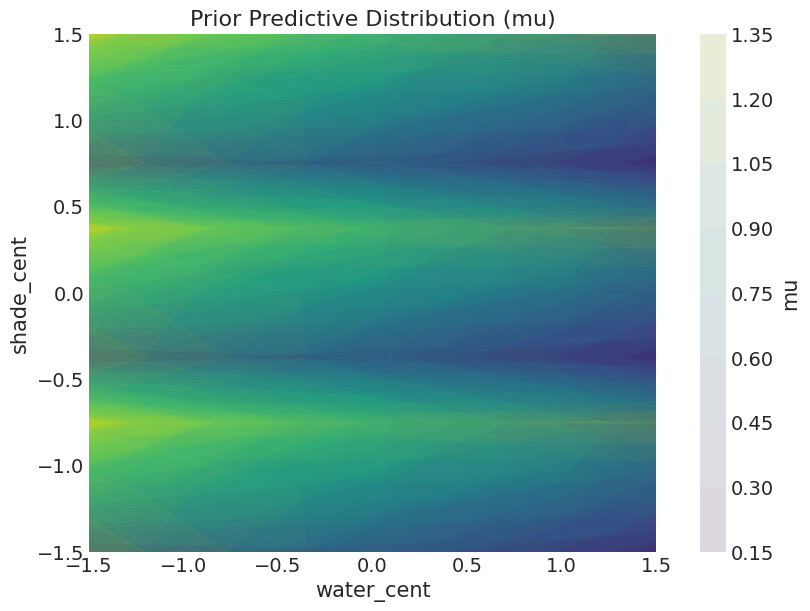

In [98]:
# Define grid
water_cent = np.linspace(-1.5, 1.5, 3)
shade_cent = np.linspace(-1.5, 1.5, 9)
ww, ss = np.meshgrid(water_cent, shade_cent)

# Shape: (chain, draw, 27) → reshape to (samples, 27)
mu_samples = m_8_5_log_prior.prior["mu"]
mu_flat = mu_samples.stack(sample=("chain", "draw")).T  # shape (27, N)
mu_flat = mu_flat.transpose("sample", ...)              # shape (N, 27)

# Plot
plt.figure(figsize=(8, 6))
for i in range(50):  # Show first 50 samples
    mu_grid = mu_flat.isel(sample=i).values.reshape(9, 3)  # reshape to match (shade, water)
    plt.contourf(ww, ss, mu_grid, alpha=0.1, cmap="viridis")

plt.xlabel("water_cent")
plt.ylabel("shade_cent")
plt.title("Prior Predictive Distribution (mu)")
plt.colorbar(label="mu")
plt.show()

In [99]:
m_8_5_log

         a ~ Normal(0.5, 0.25)
        bw ~ HalfNormal(0, 0.3)
        bs ~ HalfNormal(0, 0.3)
       bws ~ Normal(0, 0.25)
     sigma ~ Exponential(f())
        mu ~ Deterministic(f(bws, bs, a, bw))
blooms_std ~ Normal(mu, sigma)

C:\Users\risto\AppData\Local\Temp\ipykernel_28384\3694663842.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


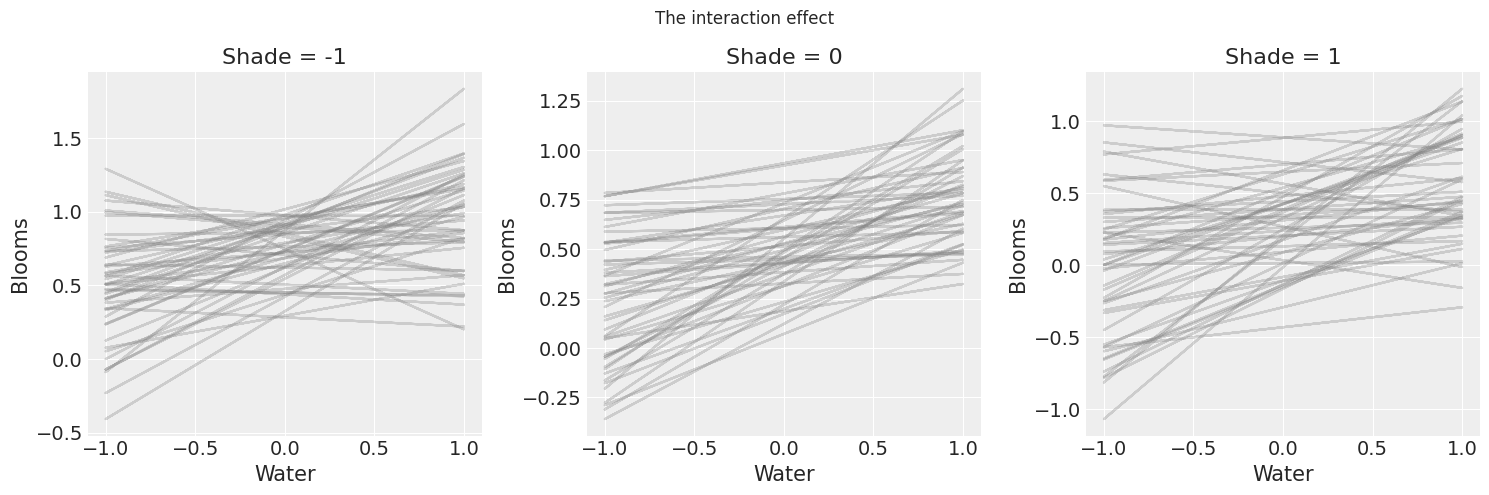

In [109]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("The interaction effect", fontsize=12)

# Handy function for plotting the lines
def line(alpha, beta1, beta2, beta12):
    return lambda x1, x2: alpha + x1 * beta1 - x2 * beta2 + x1 * x2 * beta12

# Flatten all variables from (chain, draw) to (sample,)
a_vals = m_8_5_log_prior.prior["a"].stack(sample=("chain", "draw")).values
bw_vals = m_8_5_log_prior.prior["bw"].stack(sample=("chain", "draw")).values
bs_vals = m_8_5_log_prior.prior["bs"].stack(sample=("chain", "draw")).values
bws_vals = m_8_5_log_prior.prior["bws"].stack(sample=("chain", "draw")).values

# Loop through first 50 samples
for i in range(50):
    alpha = a_vals[i]
    beta_water = bw_vals[i]
    beta_shade = bs_vals[i]
    beta_interaction = bws_vals[i]

    f = line(alpha, beta_water, beta_shade, beta_interaction)

    axs[0].plot(d["water_cent"], f(d["water_cent"], -1), color="gray", alpha=0.3)
    axs[1].plot(d["water_cent"], f(d["water_cent"], 0), color="gray", alpha=0.3)
    axs[2].plot(d["water_cent"], f(d["water_cent"], 1), color="gray", alpha=0.3)

# Add titles and labels
for ax, shade in zip(axs, [-1, 0, 1]):
    ax.set_title(f"Shade = {shade}")
    ax.set_xlabel("Water")
    ax.set_ylabel("Blooms")

plt.tight_layout()

8H1.  Return to the data(tulips) example in the chapter. Now include the bed variable as a predictor in the interaction model. Don’t interact bed with the other predictors; just include it as a main effect. Note that bed is categorical. So to use it properly, you will need to either construct dummy variables or rather an index variable, as explained in Chapter 5.

In [110]:
d

,bed,water,shade,blooms,blooms_std,water_cent,shade_cent
0,a,1,1,0.00,0.000000,-1.0,-1.0
1,a,1,2,0.00,0.000000,-1.0,0.0
2,a,1,3,111.04,0.307029,-1.0,1.0
3,a,2,1,183.47,0.507300,0.0,-1.0
4,a,2,2,59.16,0.163579,0.0,0.0
5,a,2,3,76.75,0.212216,0.0,1.0
6,a,3,1,224.97,0.622048,1.0,-1.0
7,a,3,2,83.77,0.231626,1.0,0.0
8,a,3,3,134.95,0.373141,1.0,1.0
9,b,1,1,80.10,0.221479,-1.0,-1.0


In [118]:
ind=d.bed.astype("category").cat.codes
# ind

In [120]:
with pm.Model() as m_8_5_cat:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)
    bed_offset = pm.Normal("bed_offset", 0, 0.2, shape=3)

    mu = (
        a
        + bw * d["water_cent"].values
        + bs * d["shade_cent"].values
        + bws * d["water_cent"].values * d["shade_cent"].values
        + bed_offset[ind]
        
        
    )
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"].values)

    m_8_5_cat_trace = pm.sample()
    m_8_5_cat_post = az.extract_dataset(m_8_5_trace.posterior)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bw, bs, bws, bed_offset, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


In [121]:
az.summary(m_8_5_cat_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.384,0.108,0.220,0.564,0.003,0.002,1471.0,1914.0,1.0
bw,0.206,0.031,0.154,0.252,0.000,0.001,4099.0,2897.0,1.0
bs,-0.113,0.031,-0.161,-0.064,0.001,0.001,3820.0,2583.0,1.0
bws,-0.144,0.038,-0.203,-0.085,0.001,0.001,3737.0,2328.0,1.0
bed_offset[0],-0.110,0.112,-0.301,0.056,0.003,0.002,1537.0,1800.0,1.0
bed_offset[1],0.009,0.112,-0.171,0.188,0.003,0.002,1530.0,2024.0,1.0
bed_offset[2],0.020,0.112,-0.169,0.189,0.003,0.002,1561.0,1791.0,1.0
sigma,0.130,0.022,0.097,0.160,0.000,0.000,2307.0,2208.0,1.0


8H2.  Use WAIC to compare the model from 8H1. to a model that omits bed. What do you infer from this comparison? Can you reconcile the WAIC results with the posterior distribution of the bed coefficients?

In [122]:
waic_cat = pm.compute_log_likelihood(m_8_5_cat_trace, model=m_8_5_cat)
waic_cat = pm.waic(waic_cat)

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [124]:
waic_orig = pm.compute_log_likelihood(m_8_5_trace, model=m_8_5)
waic_orig = pm.waic(waic_orig)

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [125]:
az.compare(
    {"m_8_5": m_8_5_trace, "m_8_5_cat": m_8_5_cat_trace},
    scale="deviance",
)

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m_8_5_cat,0,-27.902516,6.038966,0.000000,0.749227,6.395441,0.000000,True,deviance
m_8_5,1,-24.928323,4.338731,2.974193,0.250773,7.406935,5.175192,True,deviance


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


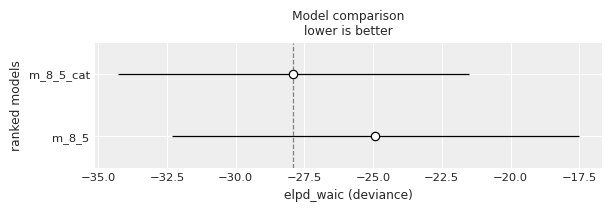

In [127]:
compare_df = az.compare(
    {
        "m_8_5": m_8_5_trace,
        "m_8_5_cat": m_8_5_cat_trace,
    },
    method="pseudo-BMA",
    ic="waic",
    scale="deviance",
)
az.plot_compare(compare_df);

model without bed is a bit better for prediction but not for sure as intervals overlap. I can see that bed_offset vaiable is not relaibliy above/under 0 and thus is does not on average add predictive accuracyt to the model

8H3.  Consider again the data(rugged) data on economic development and terrain ruggedness, examined in this chapter. One of the African countries in that example, Seychelles, is far outside the cloud of other nations, being a rare country with both relatively high GDP and high ruggedness. Seychelles is also unusual, in that it is a group of islands far from the coast of mainland Africa, and its main economic activity is tourism.

(a)  Focus on model m8.5 from the chapter. Use WAIC pointwise penalties and PSIS Pareto k values to measure relative influence of each country. By these criteria, is Seychelles influencing the results? Are there other nations that are relatively influential? If so, can you explain why?

(b)  Now use robust regression, as described in the previous chapter. Modify m8.5 to use a Student-t distribution with ν = 2. Does this change the results in a substantial way?

In [128]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

In [143]:
cid = pd.Categorical(dd["cont_africa"])
cid

[1, 0, 0, 0, 0, ..., 0, 0, 1, 1, 1]
Length: 170
Categories (2, int64): [0, 1]

In [146]:
dd.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609,0.879712,0.138342
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0.0,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929,0.964755,0.552564
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0.0,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263,1.166270,0.123992
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0.0,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032,1.104485,0.124960
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0.0,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343,0.914904,0.433409


In [160]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=2)
    b = pm.Normal("b", 0, 0.3, shape=2)
    x = pm.Data("x", dd["rugged_std"].values)
    cid = pm.intX(pm.Data("cid", dd.cont_africa))

    # mu = a[np.array(cid)] + b[np.array(cid)] * (x - 0.215)
    # mu = pm.Deterministic("mu",  a[np.array(cid)] + b[np.array(cid)] * (x - 0.215))
    mu = pm.Deterministic("mu",  a[cid] + b[cid] * (x - 0.215))
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"].values)

    idata_8_3 = pm.compute_log_likelihood(m_8_3_trace, model=m_8_3, extend_inferencedata=True)
    m_8_3_trace = pm.sample(draws=250, chains=4, return_inferencedata=True)

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 65 seconds.


In [161]:
d.shape

(234, 52)

In [163]:
waic_result = az.waic(idata_8_3, pointwise=True)
waic_df = waic_result.waic_i.to_dataframe()
waic_df.head()

C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arviz\stats\stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,waic_i
log_gdp_std_dim_0,
0,-2.533531
1,-2.400306
2,-1.680726
3,-2.406096
4,-1.627104


In [190]:
loo_result = az.loo(idata_8_3, pointwise=True)
k_values = loo_result.pareto_k
# k_values

In [191]:
# get the pointwise values for these distributions
pareto_k = loo_result.pareto_k.values
pareto_k.max()

np.float64(0.4252665619188124)

In [194]:
big = dd[pareto_k >= 0.4]
big

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std
121,LSO,426,Lesotho,6.202,4.165,17.595,1.559,90.249,3035.0,-29.580,...,0.0,7.202,3.035,6.637,4.846,26096.0,0.0,7.660371,0.899409,1.000000
198,SYC,690,Seychelles,4.885,1.802,11.129,1.278,54.101,46.0,-6.723,...,0.0,11.457,1.742,4.635,2.253,0.0,NaN,9.795761,1.150126,0.787649


In [166]:
influence_df = dd.copy()
influence_df["pareto_k"] = loo_result.pareto_k.values
influence_df["elpd_i"] = loo_result.loo_i.values
influence_df.sort_values('pareto_k', ascending=False)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std,pareto_k,elpd_i
121,LSO,426,Lesotho,6.202,4.165,17.595,1.559,90.249,3035.0,-29.580,...,3.035,6.637,4.846,26096.0,0.0,7.660371,0.899409,1.000000,0.425267,-1.065689
198,SYC,690,Seychelles,4.885,1.802,11.129,1.278,54.101,46.0,-6.723,...,1.742,4.635,2.253,0.0,NaN,9.795761,1.150126,0.787649,0.413746,1.224342
54,DJI,262,Djibouti,2.432,0.804,6.416,0.627,39.024,2318.0,11.735,...,2.682,2.351,0.064,34822.0,NaN,7.540073,0.885285,0.392132,0.288946,-2.459434
220,UZB,860,Uzbekistan,0.526,0.243,1.589,0.154,5.782,42540.0,41.633,...,NaN,NaN,NaN,1180650.0,7.5,7.323638,0.859873,0.084811,0.272981,1.092138
19,BGD,50,Bangladesh,0.186,0.065,0.502,0.053,1.817,13017.0,23.848,...,NaN,NaN,NaN,9103705.0,0.0,7.299180,0.857001,0.029990,0.265206,1.494888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,SEN,686,Senegal,0.244,0.246,0.647,0.065,0.168,19253.0,14.361,...,10.791,3.035,5.518,442565.0,1.3,7.268977,0.853455,0.039342,-0.201270,-2.516582
111,KNA,659,Saint Kitts and Nevis,0.006,0.010,0.012,0.003,0.000,26.0,17.274,...,NaN,NaN,NaN,743.0,NaN,9.325872,1.094956,0.000967,-0.216178,-2.518727
129,MDG,450,Madagascar,1.169,0.738,3.185,0.328,12.672,58154.0,-19.379,...,0.904,5.732,3.454,544859.0,0.6,6.715679,0.788492,0.188488,-0.229647,-1.789590
145,MYS,458,Malaysia,1.009,0.374,2.684,0.316,12.870,32855.0,3.791,...,NaN,NaN,NaN,296322.0,0.0,9.096774,1.068058,0.162689,-0.264834,-2.536317


In [167]:
influence_df.sort_values('elpd_i', ascending=False)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std,pareto_k,elpd_i
81,GNQ,226,Equatorial Guinea,0.559,1.405,1.449,0.177,5.540,2805.0,1.703,...,8.556,3.462,3.515,66516.0,5.75,9.628362,1.130472,0.090132,0.137857,3.158625
36,CHE,756,Switzerland,4.761,1.450,14.999,1.388,66.060,4000.0,46.806,...,NaN,NaN,NaN,600000.0,98.50,10.314315,1.211010,0.767656,0.205146,2.544153
230,YEM,887,Yemen,2.323,2.197,6.155,0.591,33.060,52797.0,15.863,...,NaN,NaN,NaN,2250000.0,0.00,6.669180,0.783032,0.374557,0.104537,2.464967
123,LUX,442,Luxembourg,0.881,0.581,2.844,0.242,1.654,259.0,49.778,...,NaN,NaN,NaN,26534.0,99.20,10.964607,1.287361,0.142051,0.200009,1.686807
19,BGD,50,Bangladesh,0.186,0.065,0.502,0.053,1.817,13017.0,23.848,...,NaN,NaN,NaN,9103705.0,0.00,7.299180,0.857001,0.029990,0.265206,1.494888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,MKD,807,The former Yugoslav Republic of Macedonia,2.665,0.885,8.190,0.783,49.405,2543.0,41.600,...,NaN,NaN,NaN,169275.0,96.31,8.709415,1.022578,0.429700,-0.128451,-2.535104
64,EST,233,Estonia,0.123,0.188,0.414,0.035,0.000,4239.0,58.673,...,NaN,NaN,NaN,69282.0,100.00,9.186330,1.078573,0.019832,0.031018,-2.536022
145,MYS,458,Malaysia,1.009,0.374,2.684,0.316,12.870,32855.0,3.791,...,NaN,NaN,NaN,296322.0,0.00,9.096774,1.068058,0.162689,-0.264834,-2.536317
218,URY,858,Uruguay,0.435,0.391,1.283,0.114,0.136,17502.0,-32.802,...,NaN,NaN,NaN,NaN,91.89,9.080405,1.066136,0.070139,0.088751,-2.537673


In [172]:
x = np.linspace(0, 1, 170)
with m_8_3:
    pm.set_data({"x": x, "cid": np.zeros(170, dtype=int)})
    other_ppc = pm.sample_posterior_predictive(
        trace=m_8_3_trace, 
        var_names=["mu", "log_gdp_std"], 
        random_seed=42
        )

    pm.set_data({"x": x, "cid": np.ones(170, dtype=int)})

    africa_ppc = pm.sample_posterior_predictive(
            trace=m_8_3_trace, 
            var_names=["mu", "log_gdp_std"], 
            random_seed=42
        )

Sampling: [log_gdp_std]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [log_gdp_std]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [181]:
africa_ppc.posterior_predictive["mu"].shape

(4, 250, 170)

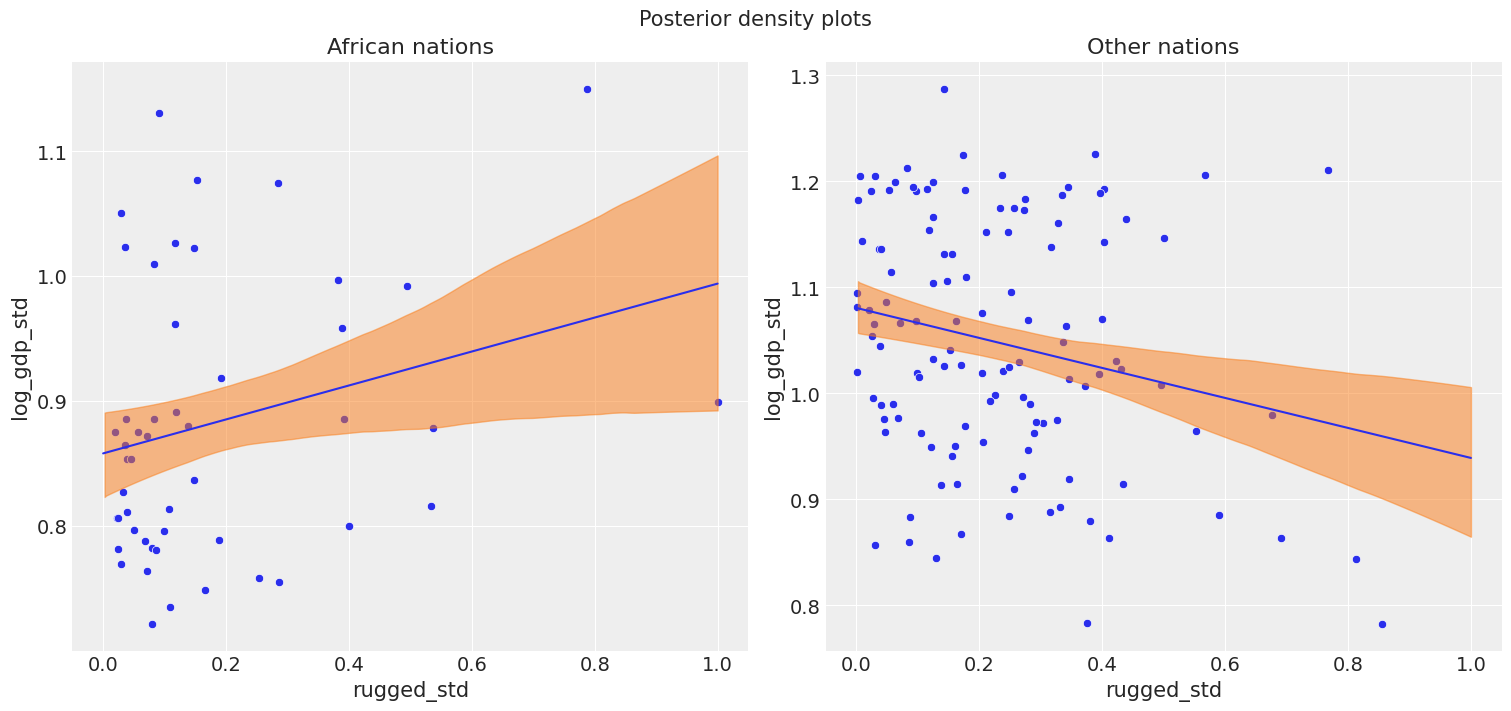

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle("Posterior density plots", fontsize=15)

sns.scatterplot(x="rugged_std", y="log_gdp_std", data=dd[dd.cont_africa == 1], ax=axs[0])
az.plot_hdi(x, africa_ppc.posterior_predictive["mu"], ax=axs[0])
axs[0].plot(x, africa_ppc.posterior_predictive["mu"].mean(['chain', 'draw']))
axs[0].set_title("African nations")

sns.scatterplot(x="rugged_std", y="log_gdp_std", data=dd[dd.cont_africa == 0], ax=axs[1])
az.plot_hdi(x, other_ppc.posterior_predictive["mu"], ax=axs[1])
axs[1].plot(x, other_ppc.posterior_predictive["mu"].mean(['chain', 'draw']))
axs[1].set_title("Other nations");

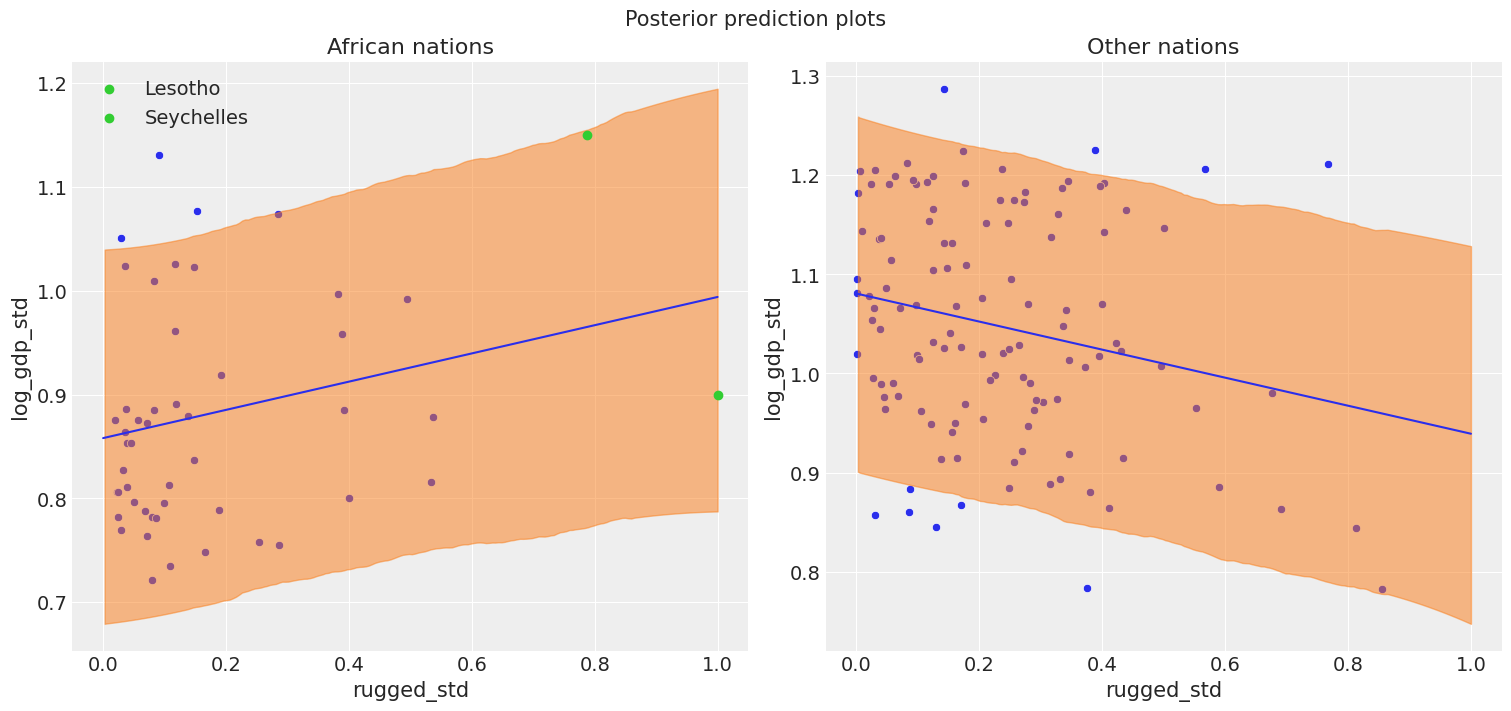

In [204]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle("Posterior prediction plots", fontsize=15)

sns.scatterplot(x="rugged_std", y="log_gdp_std", data=dd[dd.cont_africa == 1], ax=axs[0])
az.plot_hdi(x, africa_ppc.posterior_predictive["log_gdp_std"], ax=axs[0])
axs[0].plot(x, africa_ppc.posterior_predictive["mu"].mean(['chain', 'draw']))
axs[0].set_title("African nations")

axs[0].set_title("African nations")
for i in big[big.cont_africa == 1].country.values:
    axs[0].scatter(
        big[big.country == i].rugged_std,
        big[big.country == i].log_gdp_std,
        label=i,
        c="limegreen",
    )
axs[0].legend()


sns.scatterplot(x="rugged_std", y="log_gdp_std", data=dd[dd.cont_africa == 0], ax=axs[1])
az.plot_hdi(x, other_ppc.posterior_predictive["log_gdp_std"], ax=axs[1])
axs[1].plot(x, other_ppc.posterior_predictive["mu"].mean(['chain', 'draw']))
axs[1].set_title("Other nations");

Seychelles and Lesotho are most influential samples as they are in the region where we have few samples

(b)  Now use robust regression, as described in the previous chapter. Modify m8.5 to use a Student-t distribution with ν = 2. Does this change the results in a substantial way?

In [208]:
with pm.Model() as m_8_3_robust:
    a = pm.Normal("a", 1, 0.1, shape=2)
    b = pm.Normal("b", 0, 0.3, shape=2)
    x = pm.Data("x", dd["rugged_std"].values)
    cid = pm.intX(pm.Data("cid", dd.cont_africa))

    # mu = a[np.array(cid)] + b[np.array(cid)] * (x - 0.215)
    # mu = pm.Deterministic("mu",  a[np.array(cid)] + b[np.array(cid)] * (x - 0.215))
    mu = pm.Deterministic("mu",  a[cid] + b[cid] * (x - 0.215))
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.StudentT("log_gdp_std", nu=2, mu=mu, sigma=sigma, observed=dd["log_gdp_std"].values)

    m_8_3_robust_trace = pm.sample(draws=250, chains=4, return_inferencedata=True)
    idata_8_3_robust = pm.compute_log_likelihood(m_8_3_robust_trace, model=m_8_3_robust, extend_inferencedata=True)
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [210]:
loo_result = az.loo(m_8_3_robust_trace, pointwise=True)

influence_df = dd.copy()
influence_df["pareto_k"] = loo_result.pareto_k.values
influence_df["elpd_i"] = loo_result.loo_i.values
influence_df.sort_values('pareto_k', ascending=False)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std,pareto_k,elpd_i
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,NaN,NaN,NaN,200000.0,100.000,8.216929,0.964755,0.552564,0.288213,-2.659179
108,KGZ,417,Kyrgyzstan,4.287,0.948,13.105,1.246,69.767,19180.0,41.464,...,NaN,NaN,NaN,325361.0,15.000,7.352441,0.863255,0.691229,0.283364,-1.433566
230,YEM,887,Yemen,2.323,2.197,6.155,0.591,33.060,52797.0,15.863,...,NaN,NaN,NaN,2250000.0,0.000,6.669180,0.783032,0.374557,0.280866,1.758874
156,NPL,524,Nepal,5.043,1.260,14.458,1.493,75.265,14300.0,28.264,...,NaN,NaN,NaN,1852093.0,0.000,7.187561,0.843896,0.813125,0.259970,-1.450551
121,LSO,426,Lesotho,6.202,4.165,17.595,1.559,90.249,3035.0,-29.580,...,3.035,6.637,4.846,26096.0,0.000,7.660371,0.899409,1.000000,0.256498,-0.839355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,BOL,68,Bolivia,0.853,0.911,2.343,0.258,13.570,108438.0,-16.710,...,NaN,NaN,NaN,829897.0,26.732,7.782747,0.913777,0.137536,-0.197623,-0.074218
199,SYR,760,Syrian Arab Republic,0.756,0.741,2.174,0.198,6.630,18378.0,35.014,...,NaN,NaN,NaN,1306601.0,0.000,8.084006,0.949148,0.121896,-0.210352,-0.857653
95,IND,356,India,1.013,0.237,2.842,0.295,12.824,297319.0,22.876,...,NaN,NaN,NaN,77226807.0,0.000,7.789493,0.914569,0.163334,-0.249376,-0.224727
94,IDN,360,Indonesia,0.967,0.435,2.587,0.304,13.405,181157.0,-2.226,...,NaN,NaN,NaN,6987225.0,0.000,8.015748,0.941134,0.155917,-0.327233,-0.837446


In [211]:
pareto_k = loo_result.pareto_k.values
pareto_k.max()

np.float64(0.28821346906316286)

In [212]:
big = dd[pareto_k >= 0.4]
big

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std


In [215]:
x = np.linspace(0, 1, 170)
with m_8_3_robust:
    pm.set_data({"x": x, "cid": np.zeros(170, dtype=int)})
    other_ppc = pm.sample_posterior_predictive(
        trace=m_8_3_robust_trace, 
        var_names=["mu", "log_gdp_std"], 
        random_seed=42
        )

    pm.set_data({"x": x, "cid": np.ones(170, dtype=int)})

    africa_ppc = pm.sample_posterior_predictive(
            trace=m_8_3_robust_trace, 
            var_names=["mu", "log_gdp_std"], 
            random_seed=42
        )

Sampling: [log_gdp_std]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [log_gdp_std]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\risto\AppData\Local\Temp\ipykernel_28384\3152269373.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


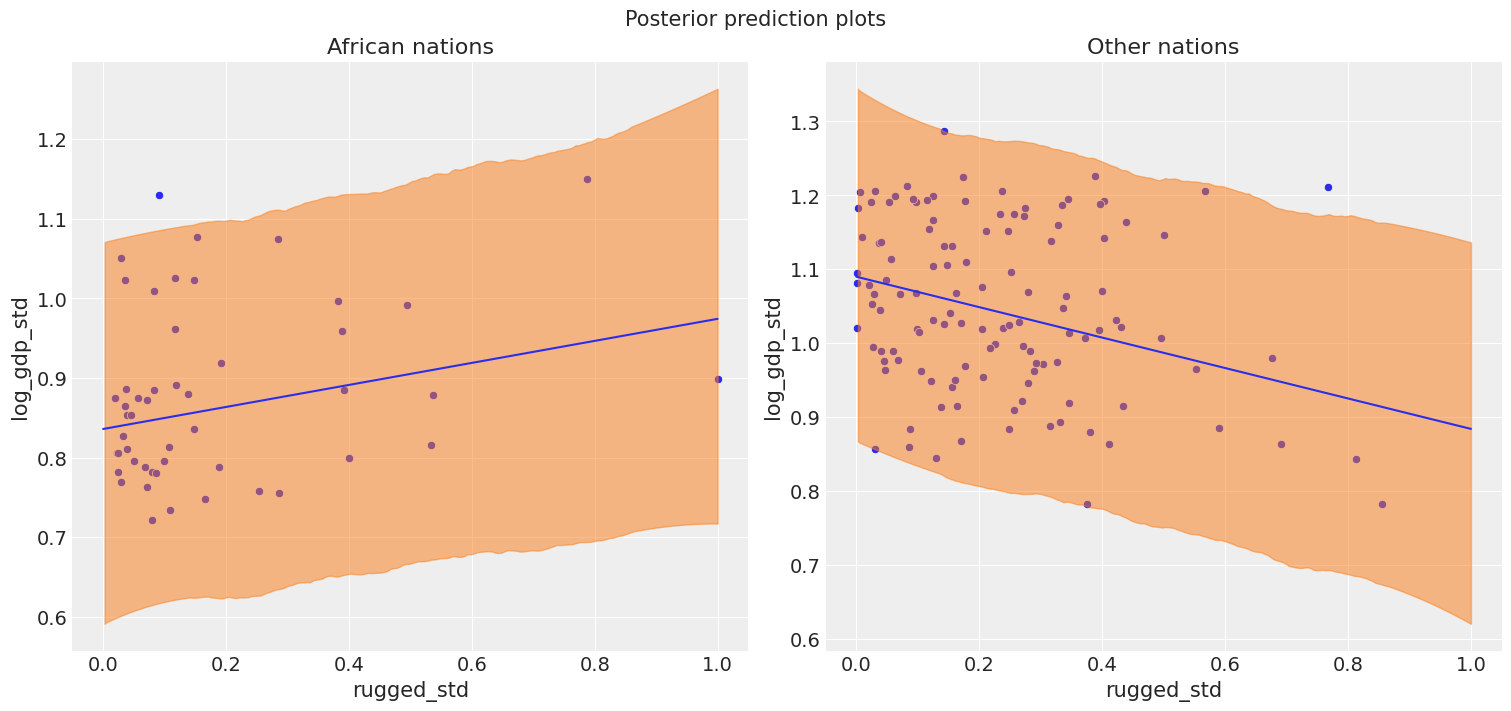

In [216]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle("Posterior prediction plots", fontsize=15)

sns.scatterplot(x="rugged_std", y="log_gdp_std", data=dd[dd.cont_africa == 1], ax=axs[0])
az.plot_hdi(x, africa_ppc.posterior_predictive["log_gdp_std"], ax=axs[0])
axs[0].plot(x, africa_ppc.posterior_predictive["mu"].mean(['chain', 'draw']))
axs[0].set_title("African nations")

axs[0].set_title("African nations")
for i in big[big.cont_africa == 1].country.values:
    axs[0].scatter(
        big[big.country == i].rugged_std,
        big[big.country == i].log_gdp_std,
        label=i,
        c="limegreen",
    )
axs[0].legend()


sns.scatterplot(x="rugged_std", y="log_gdp_std", data=dd[dd.cont_africa == 0], ax=axs[1])
az.plot_hdi(x, other_ppc.posterior_predictive["log_gdp_std"], ax=axs[1])
axs[1].plot(x, other_ppc.posterior_predictive["mu"].mean(['chain', 'draw']))
axs[1].set_title("Other nations");

8H4.  The values in data(nettle) are data on language diversity in 74 nations.143 The meaning of each column is given below.

(1)  country: Name of the country

(2)  num.lang: Number of recognized languages spoken

(3)  area: Area in square kilometers

(4)  k.pop: Population, in thousands

(5)  num.stations: Number of weather stations that provided data for the next two columns

(6)  mean.growing.season: Average length of growing season, in months

(7)  sd.growing.season: Standard deviation of length of growing season, in months

Use these data to evaluate the hypothesis that language diversity is partly a product of food security. The notion is that, in productive ecologies, people don’t need large social networks to buffer them against risk of food shortfalls. This means cultural groups can be smaller and more self-sufficient, leading to more languages per capita. Use the number of languages per capita as the outcome:

R code 8.27

d$lang.per.cap <- d$num.lang / d$k.pop

Use the logarithm of this new variable as your regression outcome. (A count model would be better here, but you’ll learn those later, in Chapter 11.) This problem is open ended, allowing you to decide how you address the hypotheses and the uncertain advice the modeling provides. If you think you need to use WAIC anyplace, please do. If you think you need certain priors, argue for them. If you think you need to plot predictions in a certain way, please do. Just try to honestly evaluate the main effects of both mean.growing.season and sd.growing.season, as well as their two-way interaction. Here are three parts to help. (a) Evaluate the hypothesis that language diversity, as measured by log(lang.per.cap), is positively associated with the average length of the growing season, mean.growing.season. Consider log(area) in your regression(s) as a covariate (not an interaction). Interpret your results. (b) Now evaluate the hypothesis that language diversity is negatively associated with the standard deviation of length of growing season, sd.growing.season. This hypothesis follows from uncertainty in harvest favoring social insurance through larger social networks and therefore fewer languages. Again, consider log(area) as a covariate (not an interaction). Interpret your results. (c) Finally, evaluate the hypothesis that mean.growing.season and sd.growing.season interact to synergistically reduce language diversity. The idea is that, in nations with longer average growing seasons, high variance makes storage and redistribution even more important than it would be otherwise. That way, people can cooperate to preserve and protect windfalls to be used during the droughts.

In [218]:
df_lang=pd.read_csv('End_of_chapter_problems/data/nettle.csv', sep=';')
df_lang.shape

(74, 7)

In [219]:
df_lang.head()

,country,num.lang,area,k.pop,num.stations,mean.growing.season,sd.growing.season
0,Algeria,18,2381741,25660,102,6.60,2.29
1,Angola,42,1246700,10303,50,6.22,1.87
2,Australia,234,7713364,17336,134,6.00,4.17
3,Bangladesh,37,143998,118745,20,7.40,0.73
4,Benin,52,112622,4889,7,7.14,0.99


In [220]:
df_lang.describe()

,num.lang,area,k.pop,num.stations,mean.growing.season,sd.growing.season
count,74.000000,7.400000e+01,74.000000,74.000000,74.000000,74.000000
mean,89.729730,8.806982e+05,33574.067568,37.905405,7.041486,1.699189
std,144.156431,1.399199e+06,102226.246085,50.883205,3.143845,1.066081
min,1.000000,1.218900e+04,102.000000,1.000000,0.000000,0.000000
25%,17.250000,1.677075e+05,3828.750000,10.000000,5.347500,0.937500
50%,40.000000,4.347960e+05,9487.000000,20.500000,7.355000,1.690000
75%,93.750000,1.080316e+06,24744.500000,44.750000,9.282500,2.107500
max,862.000000,8.511965e+06,849638.000000,272.000000,12.000000,5.870000


In [233]:
df_lang['lang_per_capita']=df_lang['num.lang']/df_lang['k.pop']
df_lang['lang_per_capita_log']=np.log(df_lang['num.lang']/df_lang['k.pop'])
df_lang['area_log']=np.log(df_lang.area)

def standardise(x):
    return (x - np.mean(x)) / np.std(x)
    
df_lang['mean_growing_season_std']=standardise(df_lang['mean.growing.season'])

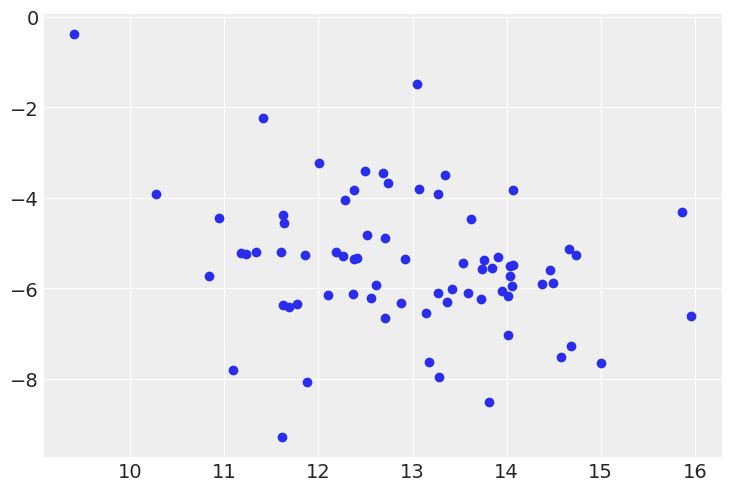

In [234]:
plt.scatter(df_lang['area_log'], df_lang['lang_per_capita_log'])

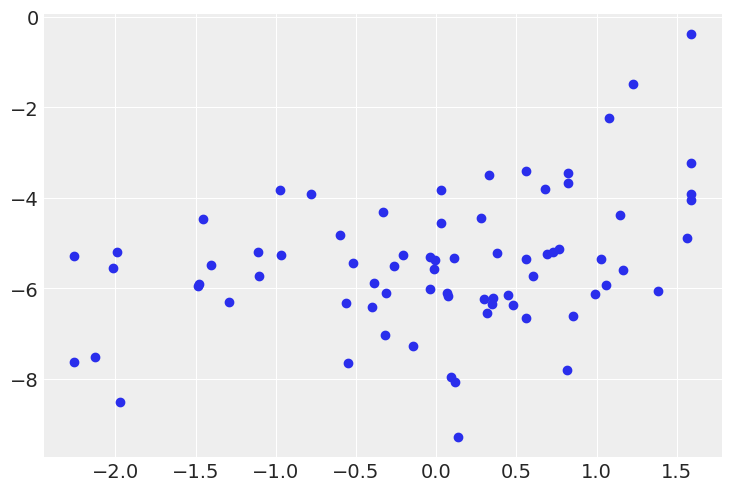

In [235]:
plt.scatter(df_lang['mean_growing_season_std'], df_lang['lang_per_capita_log'])

In [273]:
with pm.Model() as model1:
    a = pm.Normal("a", -4, 0.5)
    ba = pm.Normal("ba", 0, 0.1)
    bs = pm.Normal("bs", 0, 0.1)
    area = pm.Data("area_log", df_lang["area_log"].values)
    growing_season = pm.Data("growing_season", df_lang["mean_growing_season_std"].values)
    mu = pm.Deterministic("mu",  a + ba * area + bs* growing_season)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("lang_per_capita_log", mu=mu, sigma=sigma, observed=df_lang["lang_per_capita_log"].values)

    model1_trace = pm.sample(chains=4, return_inferencedata=True)
    # idata_model1 = pm.compute_log_likelihood(model1_trace, model=model1, extend_inferencedata=True)
    model1_prior = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, bs, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
Sampling: [a, ba, bs, lang_per_capita_log, sigma]


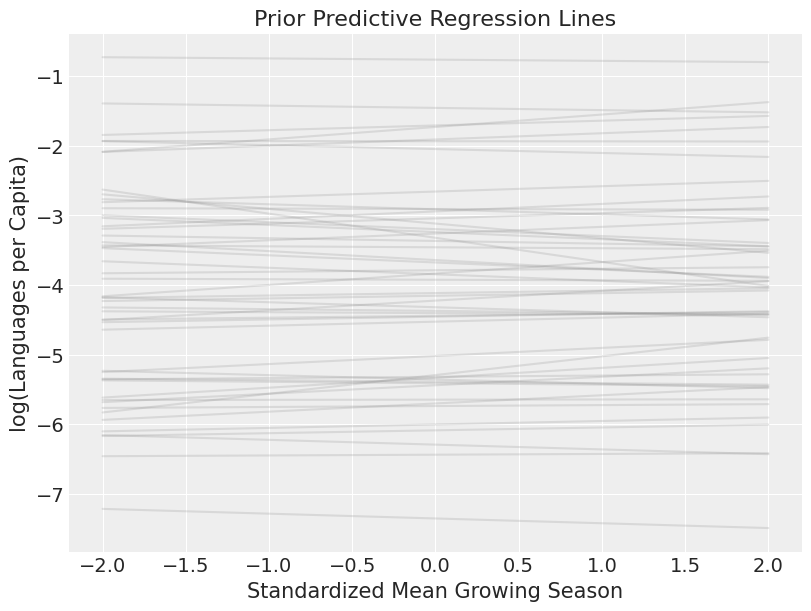

In [271]:
# Generate a sequence of growing season values (already standardized)
x = np.linspace(-2, 2, 50)

# Fix area to median value for visualization
area_val = df_lang["area_log"].median()

# Extract prior samples and flatten chains/draws into one dimension
a_samples = model1_prior.prior["a"].stack(sample=("chain", "draw")).values
ba_samples = model1_prior.prior["ba"].stack(sample=("chain", "draw")).values
bs_samples = model1_prior.prior["bs"].stack(sample=("chain", "draw")).values

# Plot the lines
plt.figure(figsize=(8, 6))
for i in range(50):  # Show 50 random prior lines
    mu = a_samples[i] + ba_samples[i] * area_val + bs_samples[i] * x
    plt.plot(x, mu, alpha=0.2, color="gray")

plt.xlabel("Standardized Mean Growing Season")
plt.ylabel("log(Languages per Capita)")
plt.title("Prior Predictive Regression Lines")
plt.grid(True)

<Axes: >

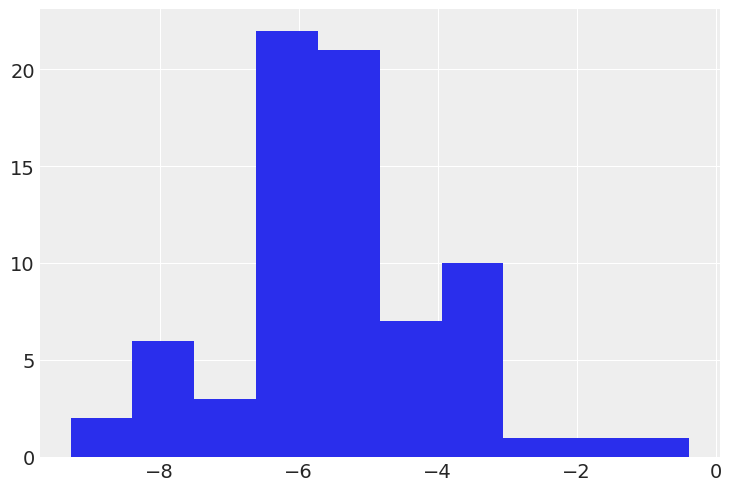

In [272]:
df_lang.lang_per_capita_log.hist()

In [274]:
az.summary(model1_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-4.003,0.453,-4.750,-3.303,0.011,0.008,1843.0,2021.0,1.0
ba,-0.112,0.036,-0.167,-0.052,0.001,0.001,1831.0,2074.0,1.0
bs,0.127,0.089,-0.023,0.262,0.002,0.001,3101.0,2505.0,1.0
sigma,1.466,0.125,1.263,1.655,0.002,0.002,2853.0,2530.0,1.0
mu[0],-5.664,0.196,-5.987,-5.366,0.003,0.003,3863.0,3305.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[69],-5.354,0.174,-5.635,-5.079,0.003,0.002,4544.0,2994.0,1.0
mu[70],-5.765,0.262,-6.164,-5.343,0.004,0.003,3717.0,3304.0,1.0
mu[71],-5.547,0.209,-5.866,-5.208,0.003,0.003,3694.0,3298.0,1.0
mu[72],-5.583,0.181,-5.873,-5.298,0.003,0.002,4463.0,3397.0,1.0


In [ ]:
area = np.linspace(df_lang.area_log.min(), df_lang.area_log.max(), 50)
season_len = np.linspace(df_lang.mean_growing_season_std.min(), df_lang.mean_growing_season_std.max(), 50)
xx1, xx2 = np.meshgrid(area, season_len)

# Flatten the grid for input to model
x1_flat = xx1.ravel()
x2_flat = xx2.ravel()

with model1:
    pm.set_data({"area_log": x1_flat, "growing_season": x2_flat})
    ppc = pm.sample_posterior_predictive(model1_trace, var_names=["mu"], random_seed=42)

Text(0.5, 1.0, 'Posterior Predictive Mean')

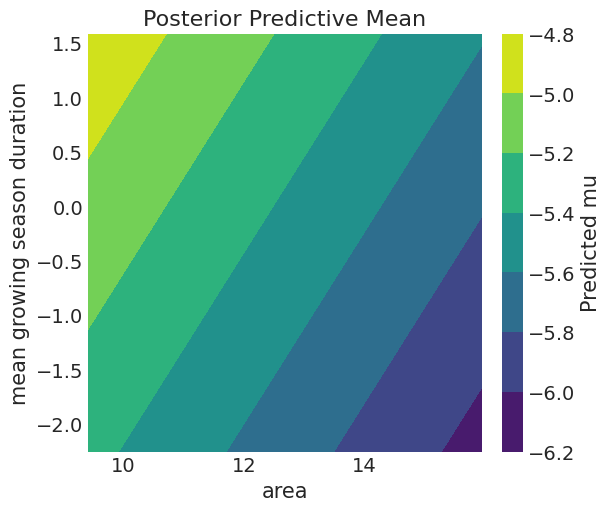

In [282]:
# Step 1: average across all draws and chains
mu_samples = ppc.posterior_predictive["mu"]  # shape: (chain, draw, 2500)
mu_mean = mu_samples.mean(dim=["chain", "draw"]).values  # shape: (2500,)

# Step 2: reshape to grid shape (50, 50)
mu_mean = mu_mean.reshape(xx1.shape)

# Step 3: plot
plt.figure(figsize=(6, 5))
plt.contourf(xx1, xx2, mu_mean, cmap="viridis")
plt.xlabel("area")
plt.ylabel("mean growing season duration")
plt.colorbar(label="Predicted mu")
plt.title("Posterior Predictive Mean")

<Axes: >

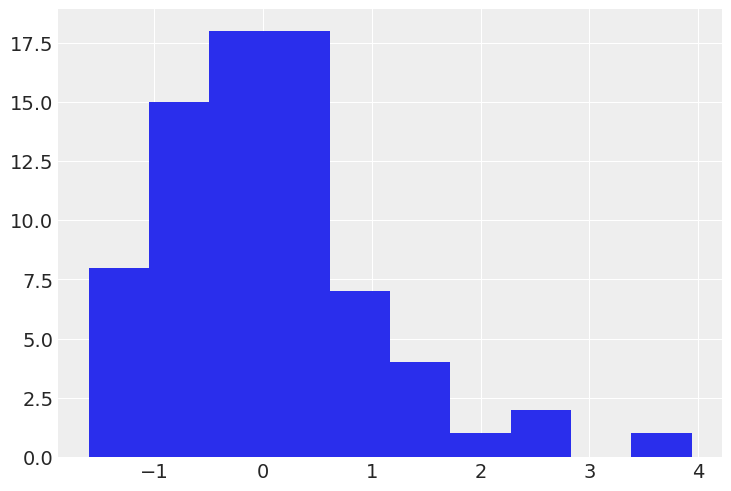

In [285]:
df_lang['sd.growing.season_std']=standardise(df_lang['sd.growing.season'])
df_lang['sd.growing.season_std'].hist()

In [288]:
with pm.Model() as model2:
    a = pm.Normal("a", -4, 0.5)
    ba = pm.Normal("ba", 0, 0.1)
    bs = pm.Normal("bs", 0, 0.1)
    area = pm.Data("area_log", df_lang["area_log"].values)
    growing_season = pm.Data("growing_season_sd_std", df_lang["sd.growing.season_std"].values)
    mu = pm.Deterministic("mu",  a + ba * area - bs* growing_season)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("lang_per_capita_log", mu=mu, sigma=sigma, observed=df_lang["lang_per_capita_log"].values)

    model2_trace = pm.sample(chains=4, return_inferencedata=True)
    # idata_model1 = pm.compute_log_likelihood(model1_trace, model=model1, extend_inferencedata=True)
    model2_prior = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, bs, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.
Sampling: [a, ba, bs, lang_per_capita_log, sigma]


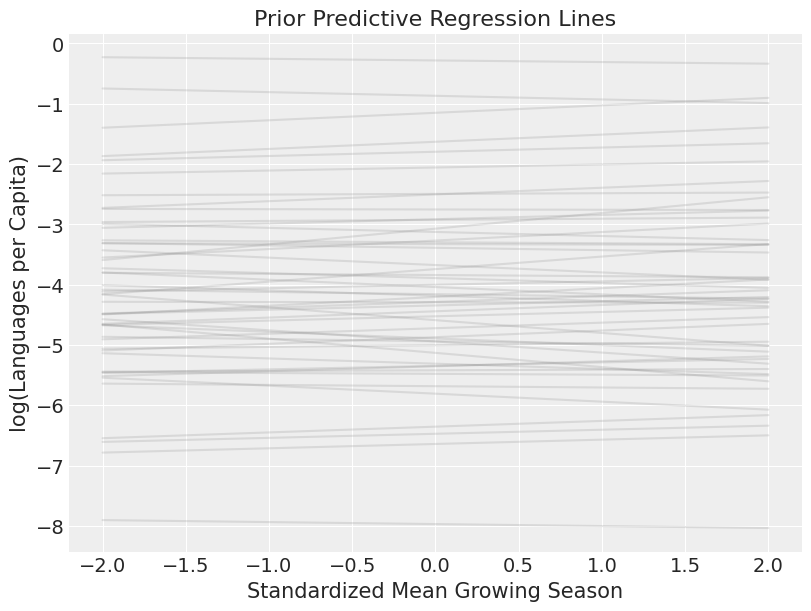

In [287]:
# Generate a sequence of growing season values (already standardized)
x = np.linspace(-2, 2, 50)

# Fix area to median value for visualization
area_val = df_lang["area_log"].median()

# Extract prior samples and flatten chains/draws into one dimension
a_samples = model2_prior.prior["a"].stack(sample=("chain", "draw")).values
ba_samples = model2_prior.prior["ba"].stack(sample=("chain", "draw")).values
bs_samples = model2_prior.prior["bs"].stack(sample=("chain", "draw")).values

# Plot the lines
plt.figure(figsize=(8, 6))
for i in range(50):  # Show 50 random prior lines
    mu = a_samples[i] + ba_samples[i] * area_val + bs_samples[i] * x
    plt.plot(x, mu, alpha=0.2, color="gray")

plt.xlabel("Standardized Mean Growing Season")
plt.ylabel("log(Languages per Capita)")
plt.title("Prior Predictive Regression Lines")
plt.grid(True)

In [290]:
area = np.linspace(df_lang.area_log.min(), df_lang.area_log.max(), 50)
season_len = np.linspace(df_lang['sd.growing.season_std'].min(), df_lang['sd.growing.season_std'].max(), 50)
xx1, xx2 = np.meshgrid(area, season_len)

# Flatten the grid for input to model
x1_flat = xx1.ravel()
x2_flat = xx2.ravel()

with model2:
    pm.set_data({"area_log": x1_flat, "growing_season_sd_std": x2_flat})
    ppc2 = pm.sample_posterior_predictive(model2_trace, var_names=["mu"], random_seed=42)

Sampling: []


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Text(0.5, 1.0, 'Posterior Predictive Mean')

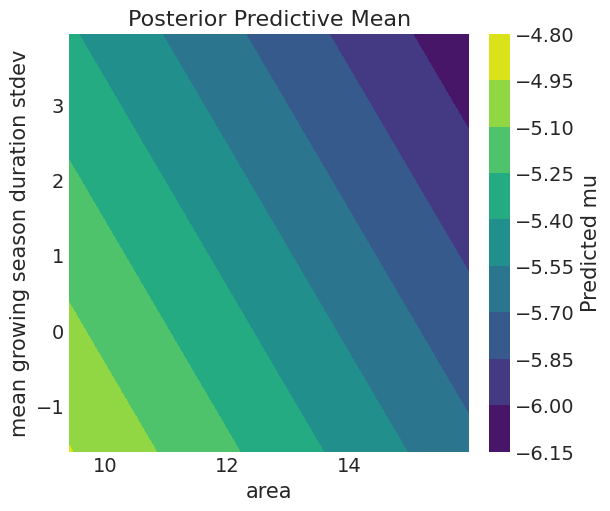

In [291]:
# Step 1: average across all draws and chains
mu_samples = ppc2.posterior_predictive["mu"]  # shape: (chain, draw, 2500)
mu_mean = mu_samples.mean(dim=["chain", "draw"]).values  # shape: (2500,)

# Step 2: reshape to grid shape (50, 50)
mu_mean = mu_mean.reshape(xx1.shape)

# Step 3: plot
plt.figure(figsize=(6, 5))
plt.contourf(xx1, xx2, mu_mean, cmap="viridis")
plt.xlabel("area")
plt.ylabel("mean growing season duration stdev")
plt.colorbar(label="Predicted mu")
plt.title("Posterior Predictive Mean")

In [292]:
az.summary(model2_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-4.038,0.460,-4.783,-3.308,0.010,0.008,2064.0,2105.0,1.0
ba,-0.110,0.037,-0.174,-0.055,0.001,0.001,1989.0,1892.0,1.0
bs,0.079,0.086,-0.059,0.220,0.002,0.001,2757.0,2423.0,1.0
sigma,1.486,0.127,1.276,1.684,0.002,0.002,2660.0,2513.0,1.0
mu[0],-5.694,0.201,-6.014,-5.371,0.003,0.003,3590.0,3000.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[69],-5.425,0.169,-5.682,-5.143,0.003,0.003,4370.0,3311.0,1.0
mu[70],-5.357,0.226,-5.715,-4.993,0.004,0.003,3319.0,3183.0,1.0
mu[71],-5.663,0.197,-5.976,-5.346,0.003,0.003,3542.0,2999.0,1.0
mu[72],-5.446,0.200,-5.777,-5.142,0.003,0.003,3549.0,3194.0,1.0


array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

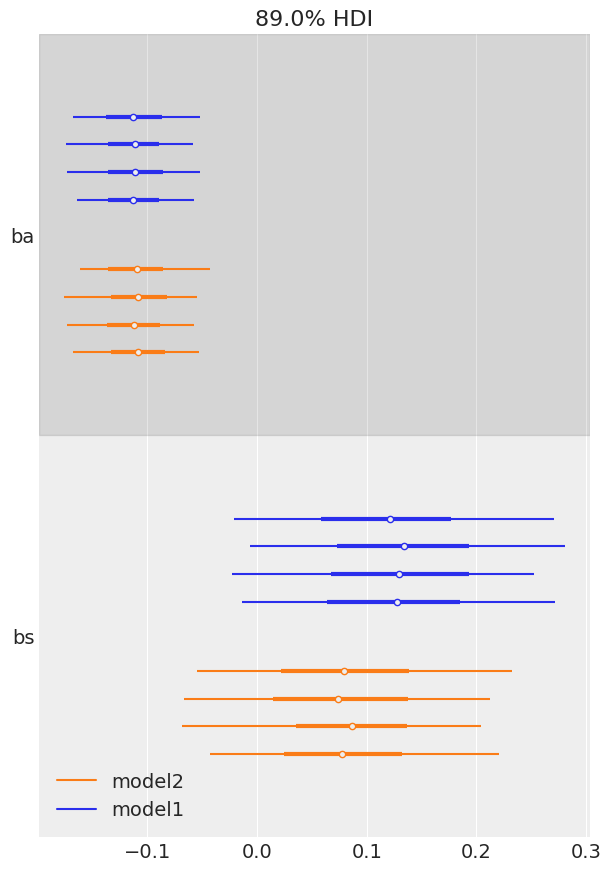

In [299]:
az.plot_forest([model1_trace, model2_trace], model_names=["model1", "model2"], var_names=["ba", "bs"])

In [302]:
with pm.Model() as model3:
    a = pm.Normal("a", -4, 0.5)
    ba = pm.Normal("ba", 0, 0.1)
    bsd = pm.Normal("bsd", 0, 0.1)
    bs = pm.Normal("bs", 0, 0.1)
    b_inter = pm.Normal("binter", 0, 0.1)
    area = pm.Data("area_log", df_lang["area_log"].values)
    growing_season_sd = pm.Data("growing_season_sd_std", df_lang["sd.growing.season_std"].values)
    growing_season = pm.Data("growing_season_std", df_lang["mean_growing_season_std"].values)
    mu = pm.Deterministic("mu",  a + ba * area - bsd* growing_season_sd + bs*growing_season + b_inter*growing_season_sd*growing_season)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("lang_per_capita_log", mu=mu, sigma=sigma, observed=df_lang["lang_per_capita_log"].values)

    model3_trace = pm.sample(chains=4, return_inferencedata=True)
    # idata_model1 = pm.compute_log_likelihood(model1_trace, model=model1, extend_inferencedata=True)
    model3_prior = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, bsd, bs, binter, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.
Sampling: [a, ba, binter, bs, bsd, lang_per_capita_log, sigma]


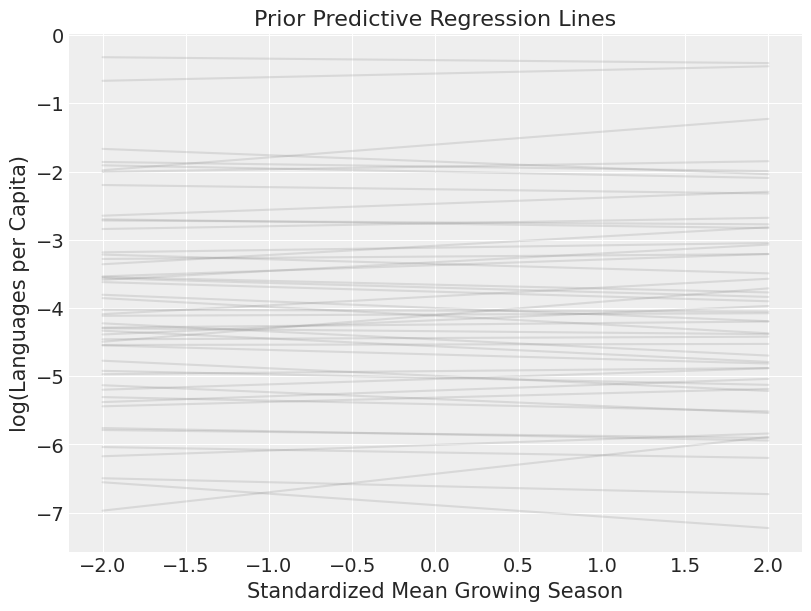

In [301]:
# Generate a sequence of growing season values (already standardized)
x = np.linspace(-2, 2, 50)

# Fix area to median value for visualization
area_val = df_lang["area_log"].median()

# Extract prior samples and flatten chains/draws into one dimension
a_samples = model3_prior.prior["a"].stack(sample=("chain", "draw")).values
ba_samples = model3_prior.prior["ba"].stack(sample=("chain", "draw")).values
bs_samples = model3_prior.prior["bs"].stack(sample=("chain", "draw")).values

# Plot the lines
plt.figure(figsize=(8, 6))
for i in range(50):  # Show 50 random prior lines
    mu = a_samples[i] + ba_samples[i] * area_val + bs_samples[i] * x
    plt.plot(x, mu, alpha=0.2, color="gray")

plt.xlabel("Standardized Mean Growing Season")
plt.ylabel("log(Languages per Capita)")
plt.title("Prior Predictive Regression Lines")
plt.grid(True)

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

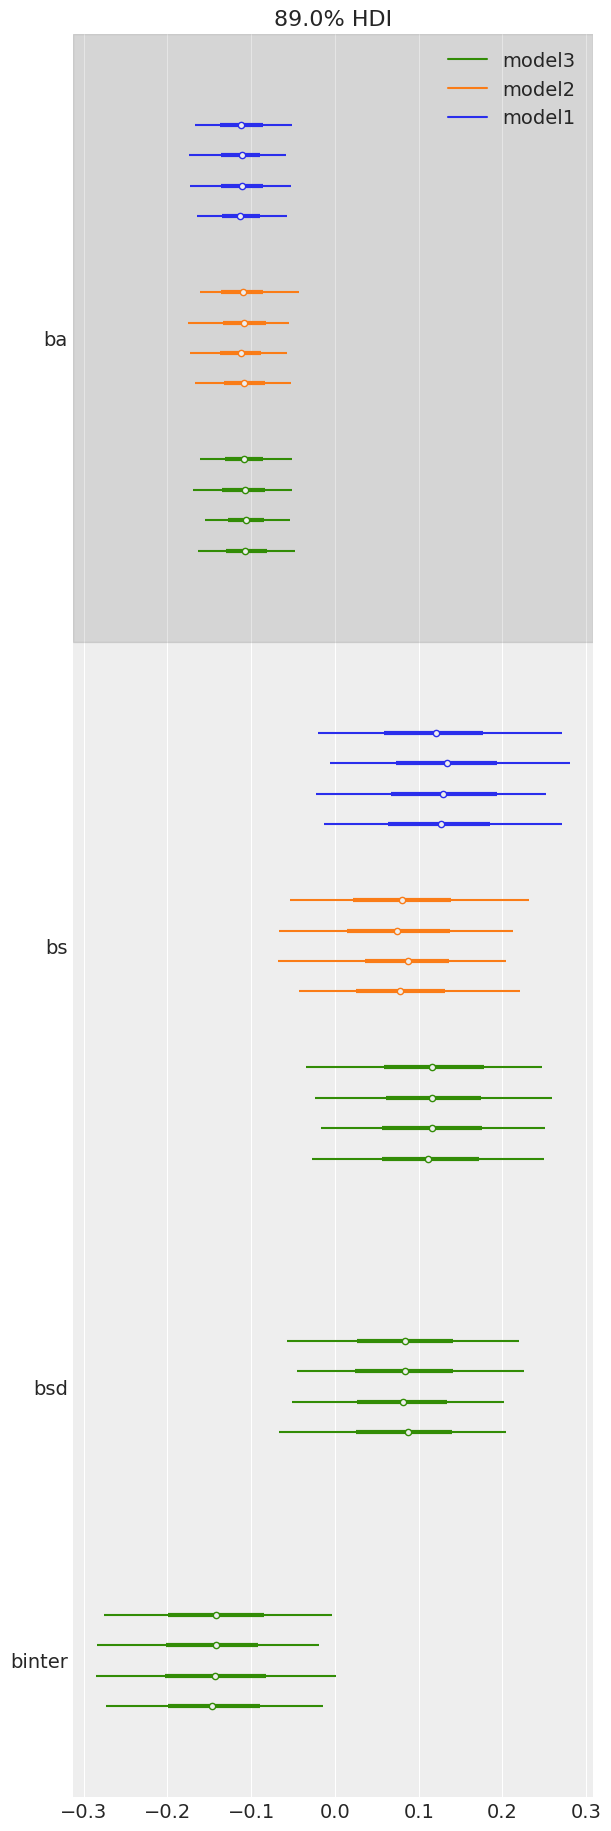

In [303]:
az.plot_forest([model1_trace, model2_trace, model3_trace], model_names=["model1", "model2", "model3"], 
               var_names=["ba", "bs", "bsd", "binter"])

In countries with longer average growing seasons, higher variability in those growing seasons is associated with a slightly stronger decrease in language diversity per capita, beyond what would be expected from each variable alone.

8H5.  Consider the data(Wines2012) data table. These data are expert ratings of 20 different French and American wines by 9 different French and American judges. Your goal is to model score, the subjective rating assigned by each judge to each wine. I recommend standardizing it. In this problem, consider only variation among judges and wines. Construct index variables of judge and wine and then use these index variables to construct a linear regression model. Justify your priors. You should end up with 9 judge parameters and 20 wine parameters. How do you interpret the variation among individual judges and individual wines? Do you notice any patterns, just by plotting the differences? Which judges gave the highest/lowest ratings? Which wines were rated worst/best on average?

In [306]:
wine = pd.read_csv("End_of_chapter_problems/data/Wines2012.csv", delimiter=";")
wine.shape

(180, 6)

In [307]:
wine.head()

,judge,flight,wine,score,wine.amer,judge.amer
0,Jean-M Cardebat,white,A1,10.0,1,0
1,Jean-M Cardebat,white,B1,13.0,1,0
2,Jean-M Cardebat,white,C1,14.0,0,0
3,Jean-M Cardebat,white,D1,15.0,0,0
4,Jean-M Cardebat,white,E1,8.0,1,0


In [316]:
wine_ids=cid = pd.Categorical(wine["wine"]).codes
judge_ids=cid = pd.Categorical(wine["judge"]).codes

wine['score_std']=standardise(wine.score)

In [317]:
len(set(wine_ids)), len(set(judge_ids))
wine_ids

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18,  0,  2,  4,  6,  8, 10, 12,
       14, 16, 18,  0,  2,  4,  6,  8, 10, 12, 14, 16, 18,  0,  2,  4,  6,
        8, 10, 12, 14, 16, 18,  0,  2,  4,  6,  8, 10, 12, 14, 16, 18,  0,
        2,  4,  6,  8, 10, 12, 14, 16, 18,  0,  2,  4,  6,  8, 10, 12, 14,
       16, 18,  0,  2,  4,  6,  8, 10, 12, 14, 16, 18,  0,  2,  4,  6,  8,
       10, 12, 14, 16, 18,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19,  1,  3,
        5,  7,  9, 11, 13, 15, 17, 19,  1,  3,  5,  7,  9, 11, 13, 15, 17,
       19,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19,  1,  3,  5,  7,  9, 11,
       13, 15, 17, 19,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19,  1,  3,  5,
        7,  9, 11, 13, 15, 17, 19,  1,  3,  5,  7,  9, 11, 13, 15, 17, 19,
        1,  3,  5,  7,  9, 11, 13, 15, 17, 19], dtype=int8)

In [330]:
wine['wine_id']=wine_ids
wine['judge_id']=judge_ids

In [331]:
with pm.Model() as m_wine:
    bw = pm.Normal("bw", 0, 0.2, shape=len(set(wine_ids)))
    bj = pm.Normal("bj", 0, 0.2, shape=len(set(judge_ids)))
    mu = pm.Deterministic("mu",  bj[judge_ids] +bw[wine_ids])
    sigma = pm.Exponential("sigma", 1)

    score_std = pm.Normal("score_std", mu=mu, sigma=sigma, observed=wine["score_std"].values)

    m_wine_trace = pm.sample(chains=4, return_inferencedata=True)
    # idata_model1 = pm.compute_log_likelihood(model1_trace, model=model1, extend_inferencedata=True)
    m_wine_prior = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bw, bj, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
Sampling: [bj, bw, score_std, sigma]


In [323]:
m_wine

       bw ~ Normal(0, 0.2)
       bj ~ Normal(0, 0.2)
    sigma ~ Exponential(f())
       mu ~ Deterministic(f(bw, bj))
score_std ~ Normal(mu, sigma)

In [325]:
az.summary(m_wine_trace, var_names='bw')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bw[0],0.052,0.170,-0.235,0.302,0.002,0.003,9694.0,2714.0,1.0
bw[1],0.038,0.164,-0.233,0.295,0.002,0.003,9823.0,2999.0,1.0
bw[2],0.094,0.167,-0.167,0.357,0.002,0.003,9471.0,2558.0,1.0
bw[3],0.195,0.166,-0.058,0.471,0.002,0.003,7850.0,3362.0,1.0
bw[4],-0.045,0.166,-0.293,0.229,0.002,0.003,10411.0,3046.0,1.0
bw[5],-0.128,0.164,-0.396,0.127,0.002,0.003,9526.0,2681.0,1.0
bw[6],0.103,0.166,-0.167,0.356,0.002,0.003,9917.0,3074.0,1.0
bw[7],0.096,0.164,-0.152,0.368,0.002,0.003,9235.0,2923.0,1.0
bw[8],0.031,0.162,-0.215,0.295,0.002,0.003,10250.0,2938.0,1.0
bw[9],0.043,0.165,-0.222,0.299,0.002,0.003,9759.0,2648.0,1.0


In [326]:
az.summary(m_wine_trace, var_names='bj')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bj[0],-0.163,0.144,-0.383,0.071,0.001,0.003,10094.0,3238.0,1.0
bj[1],0.122,0.133,-0.083,0.336,0.001,0.002,8888.0,3197.0,1.0
bj[2],0.116,0.144,-0.109,0.347,0.001,0.003,10049.0,2819.0,1.0
bj[3],-0.313,0.139,-0.531,-0.086,0.001,0.002,9112.0,3170.0,1.0
bj[4],0.461,0.144,0.220,0.675,0.001,0.003,9286.0,2904.0,1.0
bj[5],0.276,0.147,0.037,0.504,0.002,0.003,9103.0,3004.0,1.0
bj[6],0.076,0.143,-0.157,0.297,0.001,0.003,10953.0,2990.0,1.0
bj[7],-0.382,0.145,-0.608,-0.149,0.001,0.002,9719.0,3002.0,1.0
bj[8],-0.199,0.143,-0.416,0.047,0.001,0.003,10481.0,2874.0,1.0


array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

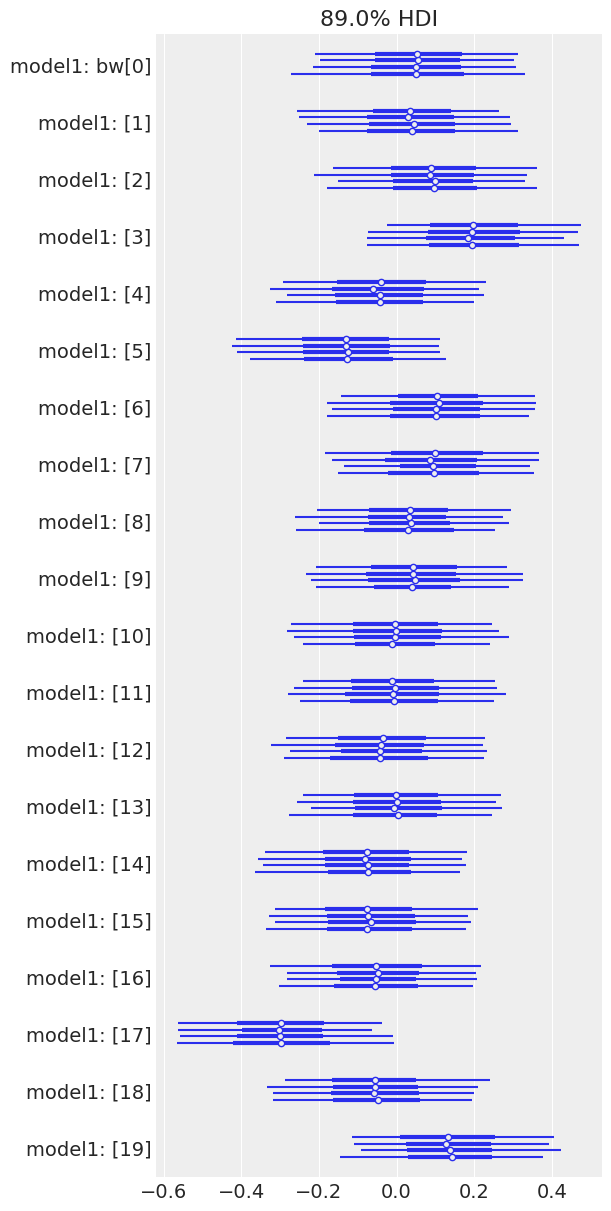

In [327]:
az.plot_forest([m_wine_trace], model_names=["model1"], 
               var_names=["bw"])

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

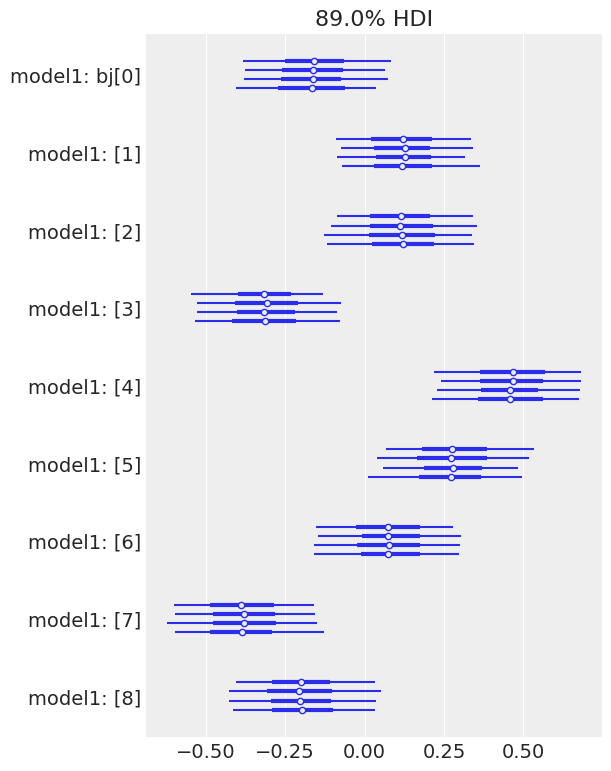

In [328]:
az.plot_forest([m_wine_trace], model_names=["model1"], 
               var_names=["bj"])

In [361]:
df_effect_wine=az.summary(m_wine_trace, var_names=["bw"])
df_effect_judge=az.summary(m_wine_trace, var_names=["bj"])
# df_effect_wine

In [362]:
df_effect_wine['wine_id']=[i for i in range(df_effect_wine.shape[0])]
df_effect_judge['judge_id']=[i for i in range(df_effect_judge.shape[0])]

df_effect_wine=pd.merge(df_effect_wine, wine[['wine_id','wine.amer', 'wine']].drop_duplicates(['wine_id']), on='wine_id', how='left')
df_effect_judge=pd.merge(df_effect_judge, wine[['judge_id','judge','judge.amer', 'wine']].drop_duplicates(['judge_id']), on='judge_id', how='left')

<Axes: ylabel='wine'>

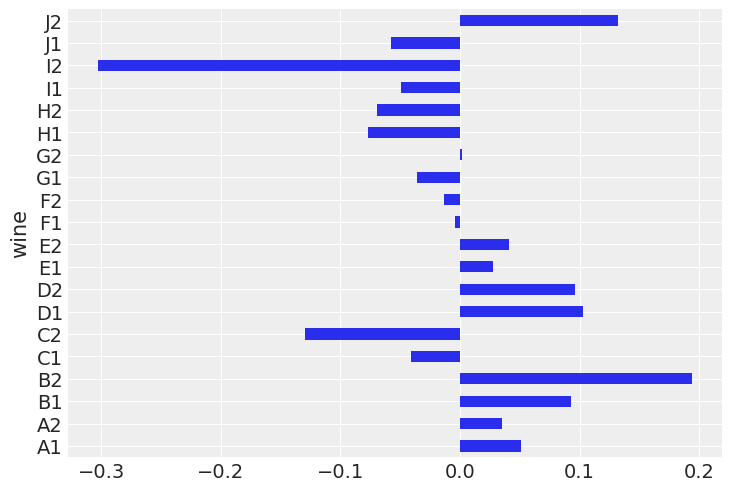

In [370]:
df_effect_wine.set_index('wine').drop_duplicates(['wine_id'])['mean'].plot(kind='barh')

<Axes: ylabel='judge'>

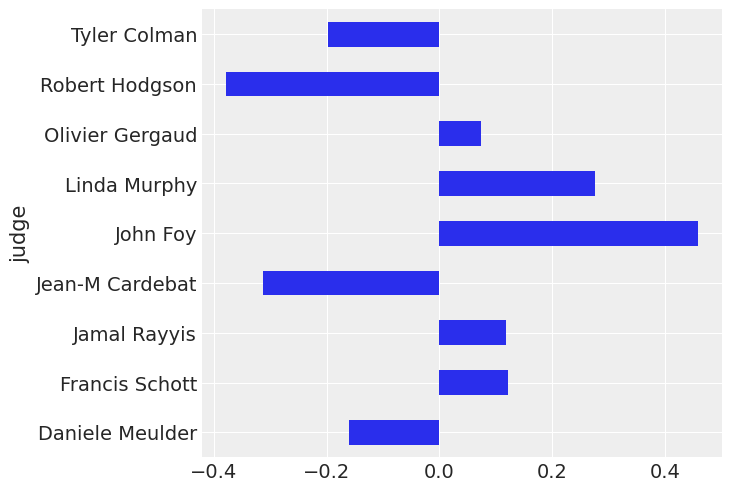

In [371]:
df_effect_judge.set_index('judge').drop_duplicates(['judge_id'])['mean'].plot(kind='barh')

8H6.  Now consider three features of the wines and judges:

(1)  flight: Whether the wine is red or white.

(2)  wine.amer: Indicator variable for American wines.

(3)  judge.amer: Indicator variable for American judges.

Use indicator or index variables to model the influence of these features on the scores. Omit the individual judge and wine index variables from Problem 1. Do not include interaction effects yet. Again justify your priors. What do you conclude about the differences among the wines and judges? Try to relate the results to the inferences in the previous problem.

In [373]:
flight_ids=cid = pd.Categorical(wine["flight"]).codes
wine_amer_ids=cid = pd.Categorical(wine["wine.amer"]).codes
judge_amer_ids=cid = pd.Categorical(wine["judge.amer"]).codes

In [374]:
wine['flight_id']=flight_ids
wine['wine_amer_ids']=wine_amer_ids
wine['judge_amer_ids']=judge_amer_ids

In [376]:
with pm.Model() as m_wine2:
    bf = pm.Normal("bf", 0, 0.2, shape=len(set(flight_ids)))
    bw = pm.Normal("bw", 0, 0.2, shape=len(set(wine_amer_ids)))
    bj = pm.Normal("bj", 0, 0.2, shape=len(set(judge_amer_ids)))
    mu = pm.Deterministic("mu",  bf[flight_ids] +bw[wine_amer_ids] + bj[judge_amer_ids])
    sigma = pm.Exponential("sigma", 1)

    score_std = pm.Normal("score_std", mu=mu, sigma=sigma, observed=wine["score_std"].values)

    m_wine2_trace = pm.sample(chains=4, return_inferencedata=True)
    # idata_model1 = pm.compute_log_likelihood(model1_trace, model=model1, extend_inferencedata=True)
    m_wine2_prior = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bf, bw, bj, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
Sampling: [bf, bj, bw, score_std, sigma]


In [377]:
az.summary(m_wine2_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bf[0],0.001,0.133,-0.221,0.206,0.002,0.002,3317.0,3115.0,1.0
bf[1],0.004,0.135,-0.214,0.212,0.002,0.002,3196.0,3162.0,1.0
bw[0],0.082,0.139,-0.140,0.300,0.002,0.002,3729.0,3451.0,1.0
bw[1],-0.070,0.135,-0.279,0.150,0.002,0.002,3336.0,3196.0,1.0
bj[0],-0.101,0.138,-0.323,0.117,0.003,0.002,2964.0,3306.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[175],0.023,0.127,-0.174,0.234,0.002,0.002,5488.0,3648.0,1.0
mu[176],0.174,0.141,-0.046,0.400,0.002,0.002,5613.0,3737.0,1.0
mu[177],0.023,0.127,-0.174,0.234,0.002,0.002,5488.0,3648.0,1.0
mu[178],0.023,0.127,-0.174,0.234,0.002,0.002,5488.0,3648.0,1.0


array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

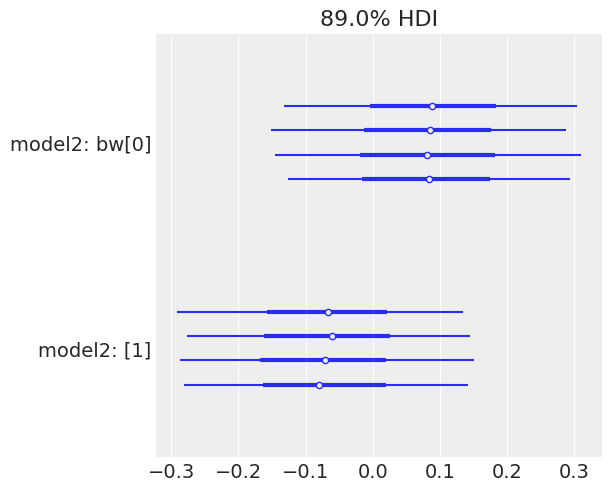

In [378]:
az.plot_forest([m_wine2_trace], model_names=["model2"], 
               var_names=["bw"])

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

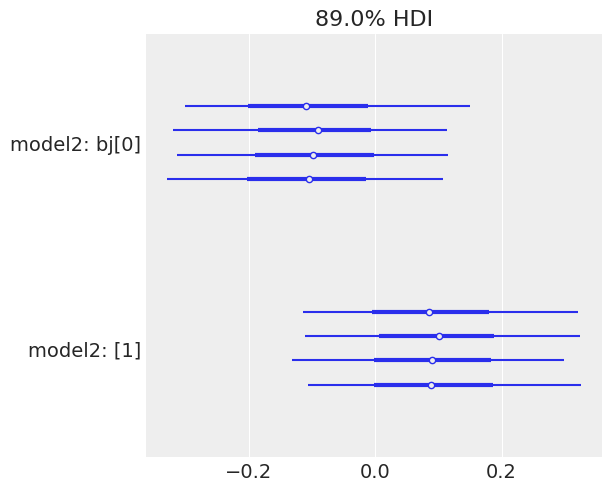

In [379]:
az.plot_forest([m_wine2_trace], model_names=["model2"], 
               var_names=["bj"])

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

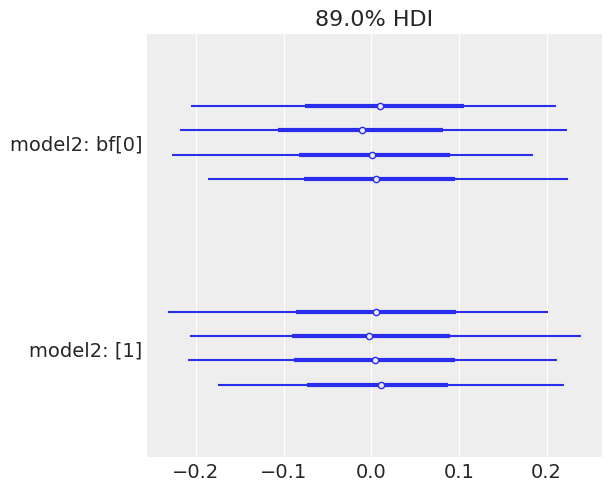

In [380]:
az.plot_forest([m_wine2_trace], model_names=["model2"], 
               var_names=["bf"])

8H7.  Now consider two-way interactions among the three features. You should end up with three different interaction terms in your model. These will be easier to build, if you use indicator variables. Again justify your priors. Explain what each interaction means. Be sure to interpret the model’s predictions on the outcome scale (mu, the expected score), not on the scale of individual parameters. You can use link to help with this, or just use your knowledge of the linear model instead. What do you conclude about the features and the scores? Can you relate the results of your model(s) to the individual judge and wine inferences from 8H5.?

In [390]:
n_wines

20

In [385]:
n_flights=len(set(flight_ids))
n_judges=len(set(judge_ids))
n_wines=len(set(wine_ids))

with pm.Model() as m_wine3:
    bf = pm.Normal("bf", 0, 0.2, shape=n_flights)
    bw = pm.Normal("bw", 0, 0.2, shape=n_wines)
    bj = pm.Normal("bj", 0, 0.2, shape=n_judges)

    judge_wine = pm.Normal("judge_wine", 0, 0.3, shape=(n_judges, n_wines))
    judge_flight = pm.Normal("judge_flight", 0, 0.3, shape=(n_judges, n_flights))
    wine_flight = pm.Normal("wine_flight", 0, 0.3, shape=(n_wines, n_flights))
    
    mu = pm.Deterministic("mu",  bf[flight_ids] +bw[wine_ids] + bj[judge_ids] 
                          + judge_wine[judge_ids, wine_ids]
                         + judge_flight[judge_ids, flight_ids]
                         + wine_flight[wine_ids, flight_ids])
    sigma = pm.Exponential("sigma", 1)

    score_std = pm.Normal("score_std", mu=mu, sigma=sigma, observed=wine["score_std"].values)

    m_wine3_trace = pm.sample(chains=4, return_inferencedata=True)
    # idata_model1 = pm.compute_log_likelihood(model1_trace, model=model1, extend_inferencedata=True)
    m_wine3_prior = pm.sample_prior_predictive()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bf, bw, bj, judge_wine, judge_flight, wine_flight, sigma]


C:\Users\risto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\
Python313\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 284 seconds.
Sampling: [bf, bj, bw, judge_flight, judge_wine, score_std, sigma, wine_flight]


In [386]:
az.summary(m_wine3_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bf[0],-0.002,0.139,-0.223,0.229,0.002,0.003,7237.0,2503.0,1.0
bf[1],0.001,0.134,-0.205,0.215,0.002,0.002,6944.0,3288.0,1.0
bw[0],0.031,0.178,-0.235,0.328,0.002,0.003,7417.0,3437.0,1.0
bw[1],0.022,0.183,-0.280,0.308,0.002,0.003,6856.0,2936.0,1.0
bw[2],0.059,0.182,-0.251,0.328,0.002,0.003,6326.0,3261.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[175],-0.094,0.390,-0.721,0.511,0.005,0.006,5916.0,3338.0,1.0
mu[176],0.069,0.378,-0.575,0.645,0.005,0.005,6372.0,3428.0,1.0
mu[177],-0.006,0.380,-0.633,0.584,0.005,0.006,5791.0,3360.0,1.0
mu[178],-0.842,0.383,-1.505,-0.274,0.005,0.006,5816.0,3005.0,1.0


array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

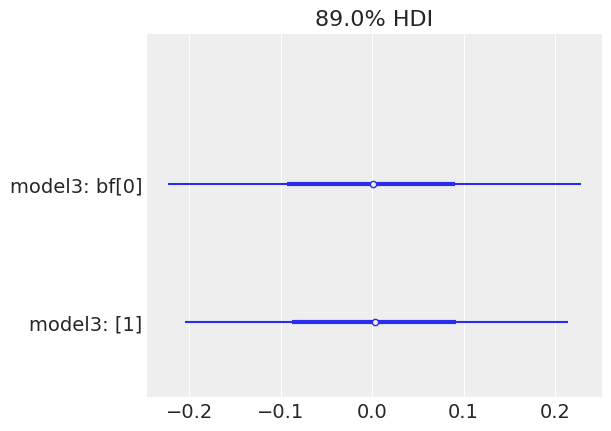

In [401]:
az.plot_forest([m_wine3_trace], model_names=["model3"], 
               var_names=["bf"],  combined=True)

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

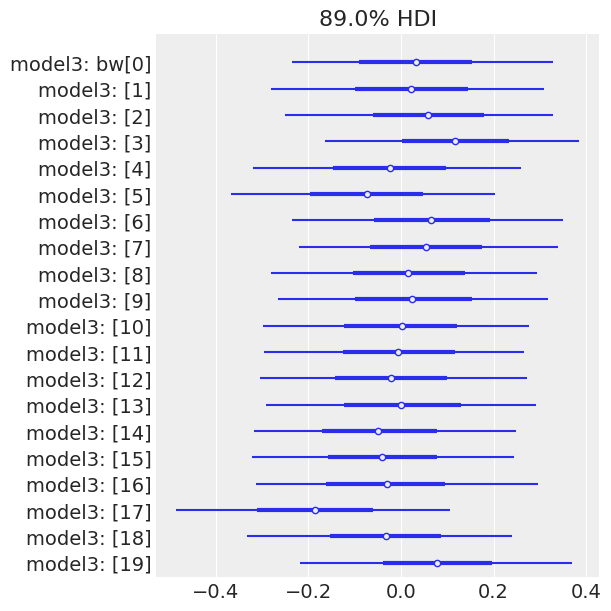

In [400]:
az.plot_forest([m_wine3_trace], model_names=["model3"], 
               var_names=["bw"],  combined=True)

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

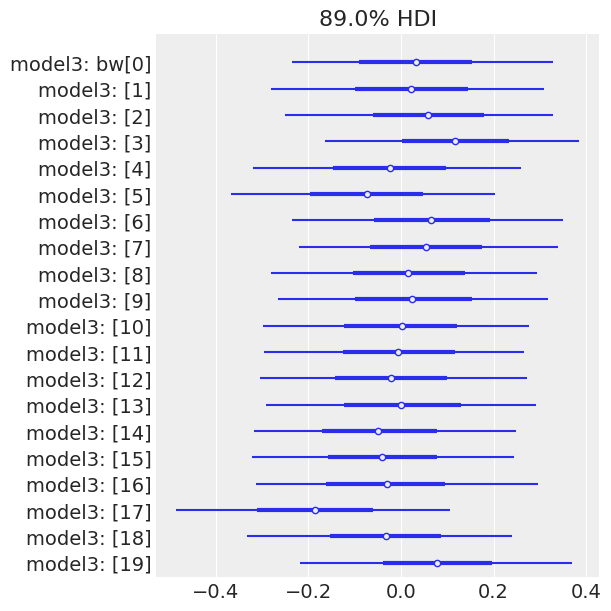

In [399]:
az.plot_forest([m_wine3_trace], model_names=["model3"], 
               var_names=["bw"],  combined=True)

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

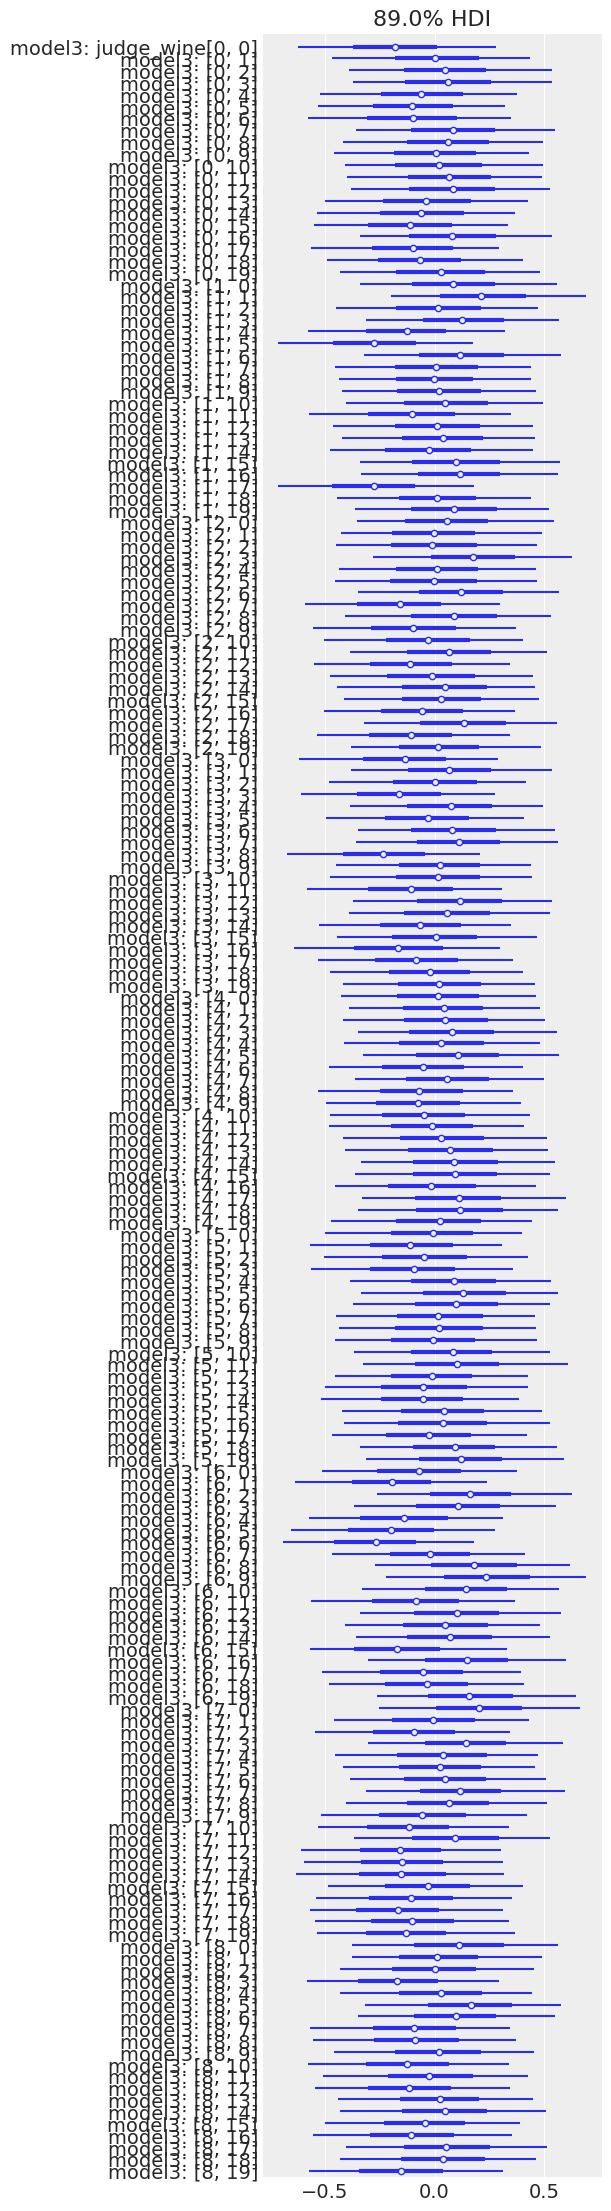

In [398]:
az.plot_forest([m_wine3_trace], model_names=["model3"], 
               var_names=["judge_wine"],  combined=True)

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

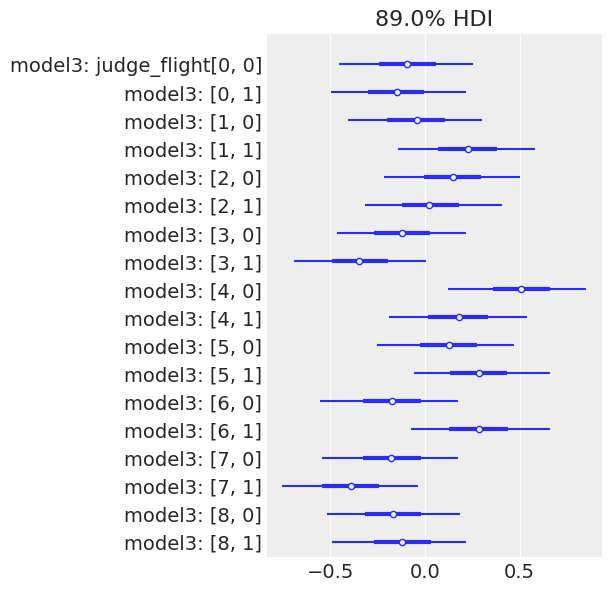

In [397]:
az.plot_forest([m_wine3_trace], model_names=["model3"], 
               var_names=["judge_flight"],  combined=True)

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

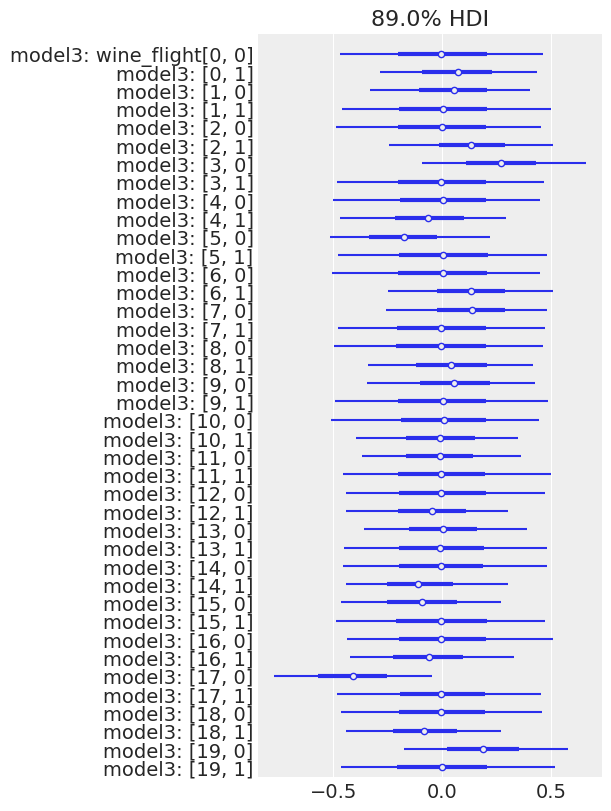

In [396]:
az.plot_forest([m_wine3_trace], model_names=["model3"], 
               var_names=["wine_flight"],  combined=True)

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Sep 05 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

matplotlib: 3.5.2
numpy     : 1.22.1
seaborn   : 0.11.2
pandas    : 1.4.2
scipy     : 1.7.3
pymc      : 4.0.0
arviz     : 0.12.1

Watermark: 2.3.1

